In [4]:
import xarray as xr
import importlib, os, gc, sys, glob
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import SXBQ as sx
import pandas as pd
import cmocean.cm as cmo
import glidertools as gt
import gsw
import gc
import os

from scipy.signal import find_peaks
from scipy.stats import linregress

## pretty colors:
import cmocean.cm as cmo
import matplotlib.colors as colors
import matplotlib.cm as cm

from argopy import DataFetcher as ArgoDataFetcher

from datetime import datetime as dt
import matplotlib.dates as mdates

import matplotlib.colors as cl
from matplotlib.colors import ListedColormap


import warnings
warnings.filterwarnings('ignore')


def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return grid,XI.T,YI.T

# Show MWL algorithm for 1 float

In [5]:
NN_af=4
# yaxis_af=np.arange(0,1000,NN_af)
yaxis_af=np.arange(0,400,NN_af)

def mask(ArgoSet):
    msk=((ArgoSet.PSAL_QC==1) & (ArgoSet.PRES_QC==1) & (ArgoSet.TEMP_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['PSAL_QC']=msk
    
def rolling_af(dff):
    tes=pd.DataFrame(dff).interpolate(limit=5, method='linear', axis=0).interpolate(limit=1, method='linear', axis=1).bfill()
    
    tes=tes.ffill(limit=1, axis=1).bfill(limit=1, axis=1).rolling(3, center=True, axis=1).median().to_numpy()
    return tes
    
def rolling_af_n2(dff):
    tes=pd.DataFrame(dff).interpolate(limit=5, method='linear', axis=0).interpolate(limit=1, method='linear', axis=1).bfill().rolling(3, center=True, axis=1).mean().to_numpy()
    return tes

def argo_process(ArgoSet):
    mask(ArgoSet)
    ArgoSet['abs_salinity'] = ('N_POINTS', gsw.SA_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['PRES']*ArgoSet['PSAL_QC']).values, ArgoSet['LONGITUDE'].values,ArgoSet['LATITUDE'].values))
    ArgoSet['cons_temp'] = ('N_POINTS',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values,(ArgoSet['PRES']*ArgoSet['PSAL_QC']).values))
    ArgoSet['conductivity']=('N_POINTS', gsw.C_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values, (ArgoSet['PRES']*ArgoSet['PSAL_QC']).values))    
    ArgoSet['potential_density'] = ('N_POINTS',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    ArgoSet['spice']=('N_POINTS', gsw.spiciness0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values) )
    
    ArgoSet=ArgoSet.rename_vars({'TIME':'time', 'PRES':'pressure',  'LONGITUDE':'longitude',  'LATITUDE':'latitude', 'CYCLE_NUMBER':'profile_num' })
    ArgoSet=ArgoSet.swap_dims({"N_POINTS": "time"}) #.sel(TIME=slice("2021-12", "2022-03"))    
    
    return ArgoSet

def time_ax_argo(dff):
    yr_min=dff.time.dt.year.min().item()
    yr_max=dff.time.dt.year.max().item()
    
    time_ax=np.array([]).astype('datetime64[D]')
    for i in np.arange(yr_min, yr_max+1):
        time_ax=np.concatenate([time_ax,np.arange(np.datetime64(str(i)+'-01-01'), np.datetime64(str(i)+'-12-31'), np.timedelta64(10, "D"))])
    return time_ax
    
def argo_timeseries(dff, variable):
    time_ax=time_ax_argo(dff)
    # time_ax=np.arange(np.datetime64(str(yr_min)+'-01-01'), np.datetime64(str(yr_max)+'-12-31'), np.timedelta64(10, "D"))
    
    tes,x, y=grid2d(dff.time.values, dff.pressure.values, dff[variable].values, xi=time_ax, yi=yaxis_af, fn='median')
    tes=rolling_af(tes)
    # pd.DataFrame(tes).interpolate(limit=5, method='linear', axis=0).interpolate(limit=2, method='linear', axis=1).bfill().to_numpy()
    # .rolling(5, center=True, axis=0).mean().rolling(3, center=True, axis=1).mean().bfill().to_numpy()

    return tes

def argo_mld(dff):
    time_ax=time_ax_argo(dff)

    sig, xx, yy=grid2d(dff.time.values, dff.pressure.values, dff.potential_density.values, xi=time_ax, yi=yaxis_af)
    sig=rolling_af(sig)
    MLD= gt.physics.mixed_layer_depth(xx.flatten().astype(float), yy.flatten(), sig.flatten(), thresh=0.125, ref_depth=2) ## changed from 0.125 to 2m
    # MLD=pd.DataFrame(np.array(MLD)).interpolate().rolling(1,center=True).mean()[0].to_numpy()
    # MLD= gt.physics.mixed_layer_depth(xx.flatten().astype(float), yy.flatten(), sig.flatten(), thresh=0.05, ref_depth=10) ## changed from 0.125 to 2m

    return MLD


def argo_n2(dff):
    time_ax=time_ax_argo(dff)

    saa,x, y=grid2d(dff.time.values, dff.pressure.values, dff['abs_salinity'].values, xi=time_ax, yi=yaxis_af, fn='median')
    ctt,x, y=grid2d(dff.time.values, dff.pressure.values, dff['cons_temp'].values, xi=time_ax, yi=yaxis_af, fn='median')
    
    sa=saa.copy()
    sa1=sa*np.nan
    sa2=sa*np.nan
    
    sa1[:-1]=gsw.Nsquared(rolling_af(saa), rolling_af(ctt), y, axis=0)[0]
    sa2[:-1]=gsw.Nsquared(rolling_af_n2(saa), rolling_af_n2(ctt), y, axis=0)[0]
    
    return sa1, sa2


def argo_PV(dff):
    time_ax=time_ax_argo(dff)

    dff['density_in_situ']=gsw.rho(dff.abs_salinity, dff.cons_temp, dff.pressure)
    rho, xx, yy=grid2d(dff.time.values, dff.pressure.values, (dff['density_in_situ']).values, xi=time_ax, yi=yaxis_af)
    sigm, xx, yy=grid2d(dff.time.values, dff.pressure.values, (dff['potential_density']).values, xi=time_ax, yi=yaxis_af)
    lat, xx, yy=grid2d(dff.time.values, dff.pressure.values, (dff['latitude']).values, xi=time_ax, yi=yaxis_af)
    
    rho=rolling_af(rho)
    sigm=rolling_af(sigm)
    
    f_param=gsw.f(np.nanmean(lat))
    sig=(sigm.copy())*np.nan
    sig[:-1, :]=f_param*rho[:-1, :]*(np.diff(sigm, axis=0)/NN_af)
    # sig=rolling_(sig)    
        
    # sig=pd.DataFrame(sig).interpolate(limit=5, method='linear', axis=0).interpolate(limit=5, method='linear', axis=1).rolling(5, center=True, axis=0).mean().rolling(3, center=True, axis=1).mean().bfill().to_numpy()
    return sig

def gridded_df_af(dff):
    time_ax=time_ax_argo(dff)

    daf_g = xr.Dataset(
    data_vars=dict(
        potential_density=(["pressure", "time"], argo_timeseries(dff,  'potential_density')),
        abs_salinity=(["pressure", "time"], argo_timeseries(dff,  'abs_salinity')),
        cons_temp=(["pressure", "time"], argo_timeseries(dff,  'cons_temp')),
        latitude=(["pressure", "time"], argo_timeseries(dff,  'latitude')),
        longitude=(["pressure", "time"], argo_timeseries(dff,  'longitude')),

        N2=(["pressure", "time"], argo_n2(dff)[0]),
        N2_roll=(["pressure", "time"], argo_n2(dff)[1]),
        
        PV=(["pressure", "time"], argo_PV(dff)),
        
        mixed_layer_depth=("time", argo_mld(dff) )
    ),
    coords=dict(
        pressure=yaxis_af,
        time=time_ax,
    ),)    
    return daf_g


def gridded_df_af_BGQ(dff):
    time_ax=time_ax_argo(dff)

    daf_g = xr.Dataset(
    data_vars=dict(
        potential_density=(["pressure", "time"], argo_timeseries(dff,  'potential_density')),
        abs_salinity=(["pressure", "time"], argo_timeseries(dff,  'abs_salinity')),
        cons_temp=(["pressure", "time"], argo_timeseries(dff,  'cons_temp')),
        latitude=(["pressure", "time"], argo_timeseries(dff,  'latitude')),
        longitude=(["pressure", "time"], argo_timeseries(dff,  'longitude')),
        oxygen_concentration=(["pressure", "time"], argo_timeseries(dff,  'oxygen_concentration')),

        N2=(["pressure", "time"], argo_n2(dff)[0]),
        N2_roll=(["pressure", "time"], argo_n2(dff)[1]),
        
        PV=(["pressure", "time"], argo_PV(dff)),
        
        mixed_layer_depth=("time", argo_mld(dff) )
    ),
    coords=dict(
        pressure=yaxis_af,
        time=time_ax,
    ),)    
    return daf_g

def regrid_to_2D(variable):
    pr=(df_argo_prepros.pressure)*np.nan
    pr.T[0]=df_argo_prepros[variable]
    pr=pr.ffill('n_levels')
    return pr

def mask_bgq(ArgoSet):
    msk=((ArgoSet.DOXY_ADJUSTED_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['DOXY_ADJUSTED_QC']=msk
    
def argo_process_bgq(ArgoSet):
    ArgoSet=ArgoSet.set_coords(['latitude', 'longitude'])
    mask_bgq(ArgoSet)    
    ArgoSet['abs_salinity'] = ('time', gsw.SA_from_SP((ArgoSet['salinity']).values,(ArgoSet['pressure']).values, ArgoSet['longitude'].values,ArgoSet['latitude'].values))
    ArgoSet['cons_temp'] = ('time',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['temperature']).values,(ArgoSet['pressure']).values))
    ArgoSet['potential_density'] = ('time',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    ArgoSet['oxygen_concentration'] =ArgoSet['DOXY_ADJUSTED']*ArgoSet['DOXY_ADJUSTED_QC']
    
    return ArgoSet


def _get_bottom_top_mode_water(float_):
    float_['dens_baseml']=float_.sel(pressure=(float_.mixed_layer_depth.ffill('time').bfill('time'))+4).potential_density
    # float_['dens_baseml']=float_.sel(pressure=(float_.mixed_layer_depth.ffill('time').bfill('time'))).potential_density
    
    plt.figure(figsize=(25,5))
    plt.plot(float_.time, float_['dens_baseml'])
    plt.plot(float_.time, float_['dens_baseml'].rolling(time=1, center=True).median(), c='k')

    if (float_.latitude.mean().values>20) == True:
        dist_to_find_peaks=10*2
    else: 
        dist_to_find_peaks=10
 

    rol_dens=float_['dens_baseml'].rolling(time=1, center=True).median()
    peaks, _ = find_peaks(rol_dens, distance=dist_to_find_peaks) #distance=20)
    plt.scatter(float_.time[peaks], rol_dens[peaks], c='r', zorder=10)

    DEN_ARR=np.arange(len(float_.time))*0.0
    peaks=np.concatenate([[0], peaks])
    DEN_ARR[peaks]=rol_dens[peaks]

    float_['density_MW']=('time', DEN_ARR)
    float_['density_MW'][DEN_ARR==0]=np.nan
    float_['density_MW']=float_['density_MW'].ffill('time')

    float_['mwd']=('time',(np.ma.masked_invalid(np.abs(float_['potential_density']-float_['density_MW']))[:].argmin(axis=0))*NN_af)
    float_['mwd']=float_['mwd'].astype(float)
    float_['mwd'][float_['mwd']==0]=np.nan
    float_['mwd'][float_['mwd'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['mwd'].values<float_['mixed_layer_depth'].values]
    float_['mixed_layer_depth'][float_['mixed_layer_depth']==0]=np.nan

    minn2, bot_array, top_array=[],[],[]

    vmini, vmaxi=0, len(float_.time)
    for N in range(vmini,vmaxi):
        if ((np.isfinite(float_.mixed_layer_depth[N])==False) or (np.isfinite(float_.mwd[N])==False)):
                        minn2.append(np.nan)
                        bot_array.append(np.nan)
                        top_array.append(np.nan)   
        else:
            n2_prof=1/np.abs(float_.N2_roll[int(float_.mixed_layer_depth[N]/NN_af)+2:int(float_.mwd[N]/NN_af)-1, N][::-1])
            if len(n2_prof)<1:
                minn2.append(np.nan)
                bot_array.append(np.nan)
                top_array.append(np.nan)   

            else:
                peaks_n2=int(float_.mwd[N]/NN_af)-2-np.argmax(n2_prof.values)    

                sig_pfog=float_.potential_density[:, N]
                refdpt=peaks_n2

                bot_lay=gt.physics.mixed_layer_depth(np.ones(len(yaxis_af)), yaxis_af, sig_pfog, thresh=0.05, ref_depth=refdpt*NN_af)

                siginv=28-sig_pfog[:refdpt][::-1]
                yinv=np.arange(len(siginv))

                top_lay=gt.physics.mixed_layer_depth(np.ones(len(yinv)), yinv, siginv, thresh=0.05, ref_depth=0)  ##### TOP_LAY= (refddpt-13)*2
                # print(bot_lay, top_lay)

                bott=bot_lay[1]
                topp=(refdpt-top_lay[1])*NN_af

                minn2.append(refdpt*NN_af)
                bot_array.append(bott)
                top_array.append(topp)   
                # print(N)
    float_['top_mwl']=('time', np.array(top_array))
    float_['bot_mwl']=('time', np.array(bot_array))    
    float_['min_n2']=('time', np.array(minn2))    
    
    
    float_['top_mwl'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]

    return float_

##  Load data

In [6]:
df_argo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/datasets/ARGO_30_80_-5_30_2001_2023_fetcher.nc')

def mask(ArgoSet):
    msk=((ArgoSet.PSAL_QC==1) & (ArgoSet.PRES_QC==1) & (ArgoSet.TEMP_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['PSAL_QC']=msk

    
def argo_process(ArgoSet):
    mask(ArgoSet)
    ArgoSet['abs_salinity'] = ('time', gsw.SA_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values, ArgoSet['longitude'].values,ArgoSet['latitude'].values))
    ArgoSet['cons_temp'] = ('time',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))
    # ArgoSet['conductivity']=('time', gsw.C_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values, (ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))    
    ArgoSet['potential_density'] = ('time',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    # ArgoSet['spice']=('time', gsw.spiciness0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values) )    
    
    ArgoSet=ArgoSet.rename_vars({'PLATFORM_NUMBER':'platform_num' })    
    return ArgoSet

df_argo=argo_process(df_argo)

vars_to_drop=['CONFIG_MISSION_NUMBER',
 'DATA_MODE',
 'DIRECTION',
 'POSITION_QC',
 'PRES_QC',
 'PSAL',
 'PSAL_QC',
 'TEMP',
 'TEMP_QC',
 'TIME_QC',
 'N_POINTS',
 'conductivity',
 'spice']

df_argo=df_argo.drop_vars(vars_to_drop)
df_argo=df_argo.where(df_argo.potential_density>20).where(df_argo.potential_density<30).where(df_argo.abs_salinity>34).where(df_argo.cons_temp>5)
# grid per platform
ds_platform_num=df_argo.groupby('platform_num')

del df_argo
gc.collect()

PlatformNum=list(ds_platform_num.groups.keys())
platforms_good=[]
for i in tqdm(PlatformNum):
    dff=ds_platform_num[i]
    num_days=((dff.time.max()-dff.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
    lat, lon=np.nanmean(dff.latitude), np.nanmean(dff.longitude)
    if (num_days>(30*3)):
    # if (num_days>(30*3)) & (lat>10):
        platforms_good.append(i)
        
platforms_numbers=np.array(platforms_good)

len(platforms_numbers)

  0%|          | 0/678 [00:00<?, ?it/s]

579

In [ ]:
# for i in range(0, len(platforms_numbers)):
#     float_1=ds_platform_num[platforms_numbers[i]]#206
#     float_1=gridded_df_af(float_1)
#     plt.title(str(i)+'  '+str(float_1.time[0].dt.year.item())+'  '+str(float_1.time[-1].dt.year.item()))
#     plt.scatter(float_1.longitude,float_1.latitude)
#     plt.ylim(5,30)
#     plt.xlim(40,75)
#     plt.show()

## Process 1 float

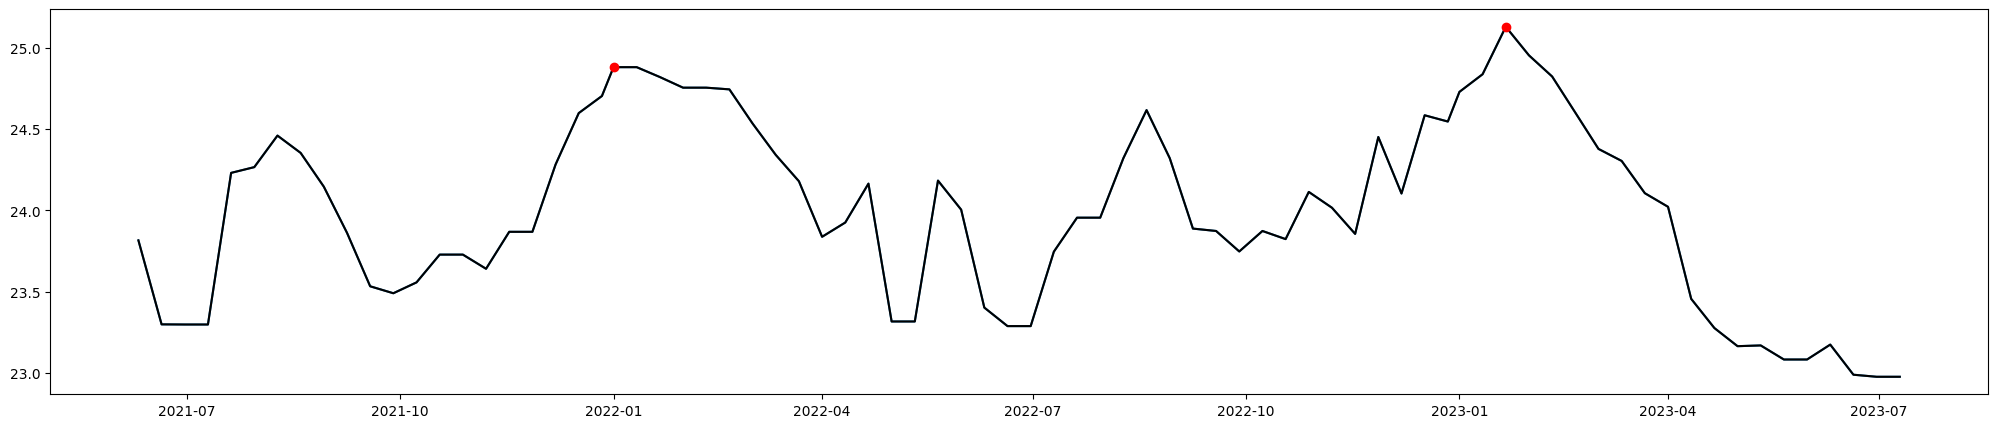

In [7]:
float_1=ds_platform_num[6903059] #2901444] #2901427] #2901465]#206 268 220 230
float_1=gridded_df_af(float_1)
float_1=_get_bottom_top_mode_water(float_1)

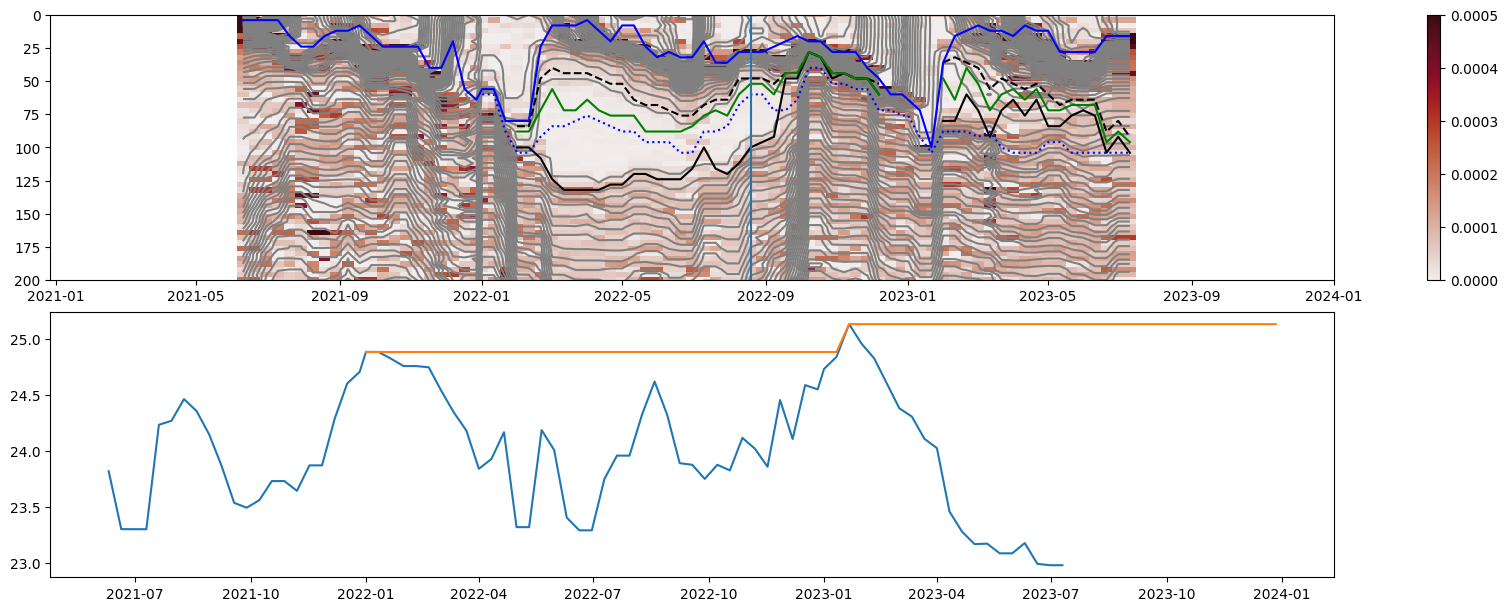

In [8]:
plt.figure(figsize=(15,6), constrained_layout=True)
plt.subplot(211)
plt.pcolormesh(float_1.time, float_1.pressure, float_1.N2, vmin=0, vmax=0.0005, cmap=cmo.amp)
# plt.pcolormesh(float_1.time, float_1.pressure, float_1.oxygen_concentration, vmin=0, vmax=200, cmap=cmo.dense)
plt.colorbar()

plt.contour(float_1.time, float_1.pressure, float_1.potential_density, levels=np.arange(22, 28, 0.05), colors='gray')
# plt.pcolormesh(float_1.time, float_1.pressure, float_1.oxygen_concentration, cmap=cmo.dense)

# plt.pcolormesh(float_1.time, float_1.pressure, float_1.cons_temp, cmap=cmo.thermal, vmin=13, vmax=32)

plt.ylim(200,0)

plt.plot(float_1.time,float_1.bot_mwl, c='k')
plt.plot(float_1.time,float_1.top_mwl, c='k', ls='--')
plt.plot(float_1.time,float_1.min_n2, c='g')
plt.plot(float_1.time,float_1.mwd, c='b', ls=':')
# plt.xlim(pd.to_datetime('2014-01'), pd.to_datetime('2017-06'))
# plt.xlim(pd.to_datetime('2010-01'), pd.to_datetime('2015-06'))

# plt.plot(float_1.time,float_1.mwd, c='g')

plt.plot(float_1.time,float_1.mixed_layer_depth, c='b')
N=60
plt.axvline(float_1.time.values[N])

plt.subplot(212)
plt.plot(float_1.time, float_1.dens_baseml)
plt.plot(float_1.time, float_1.density_MW)
# plt.xlim(pd.to_datetime('2010-01'), pd.to_datetime('2015-06'))
# plt.ylim(200,0)

# plt.xlim(pd.to_datetime('2014-01'), pd.to_datetime('2017-06'))


In [ ]:
# float_1=_get_bottom_top_mode_water(float_1)

<xarray.DataArray 'min_n2' ()>
array(52.)
Coordinates:
    time     datetime64[ns] 2022-08-19


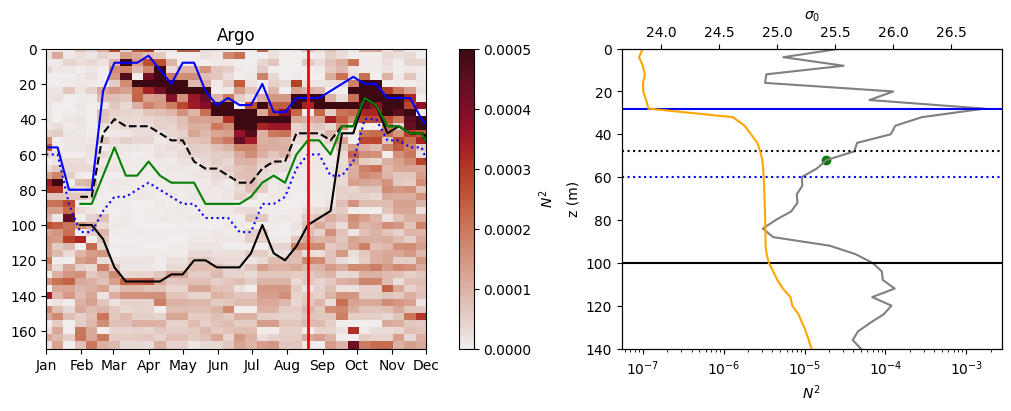

In [10]:
plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(121)
plt.title('Argo')

plt.pcolormesh(float_1.time, float_1.pressure, float_1.N2, vmin=0, vmax=0.0005, cmap=cmo.amp)
# plt.pcolormesh(float_1.time, float_1.pressure, float_1.abs_salinity,  cmap=cmo.dense)
cb=plt.colorbar()
cb.set_label('$N^2$')

# plt.contour(float_1.time, float_1.pressure, float_1.oxygen_concentration, levels=[120], colors='w', linestyles=':')
# plt.contour(float_1.time, float_1.pressure, float_1.oxygen_concentration, levels=[60], colors='w')

# plt.pcolormesh(float_1.time, float_1.pressure, float_1.cons_temp, cmap=cmo.thermal, vmin=13, vmax=32)

plt.ylim(170,0)

plt.plot(float_1.time,float_1.bot_mwl, c='k')
plt.plot(float_1.time,float_1.top_mwl, c='k', ls='--')
plt.plot(float_1.time,float_1.min_n2, c='g')
plt.plot(float_1.time,float_1.mwd, c='b', ls=':')

# plt.plot(float_1.time,float_1.mwd, c='g')

plt.plot(float_1.time,float_1.mixed_layer_depth, c='b')
# N=100
plt.axvline(float_1.time.values[N], c='r', lw=2)

plt.xlim(pd.to_datetime('2022-01'), pd.to_datetime('2022-12'))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=3))
    
plt.subplot(122)
float_=float_1
# N=88
print(float_.min_n2[N])
# plt.figure(figsize=(3,4))

plt.plot(np.abs(float_.N2_roll[:, N]), yaxis_af, c='gray')
# plt.xlim(0,0.1e6)
# plt.axvline(0, c='gray')
plt.xscale('log')
plt.ylabel('z (m)')

plt.axhline(float_.mixed_layer_depth[N], c='b')
plt.axhline(float_.mwd[N], c='b', ls=':')
# plt.axhline(float_.mwd[N]-4, c='b')
plt.xlabel('$N^2$')
plt.axhline(float_.top_mwl[N], c='k', ls=':')
plt.axhline(float_.bot_mwl[N], c='k')
plt.scatter(float_.N2_roll[:, N][int(float_.min_n2[N]/NN_af)], yaxis_af[int(float_.min_n2[N]/NN_af)], c='g')

plt.twiny()
plt.plot(float_.potential_density[:, N], yaxis_af, c='orange')
# for i in np.arange(24.8,25.3, 0.05):
#     plt.axvline(i, alpha=0.5)
plt.xlabel('$\sigma_0$')

# plt.xlim(23.5, 25.5)
# plt.twiny()
# plt.plot(float_.oxygen_concentration[:, N], yaxis_af, c='b')

plt.ylim(140,0)


# sig_pfog=float_.potential_density[:, N]
# refdpt=peaks_n2
# print(refdpt)
# bot_lay=gt.physics.mixed_layer_depth(np.ones(len(yaxis)), yaxis, sig_pfog, thresh=0.05, ref_depth=refdpt*2)

# siginv=28-sig_pfog[:refdpt][::-1]
# yinv=np.arange(len(siginv))

# top_lay=gt.physics.mixed_layer_depth(np.ones(len(yinv)), yinv, siginv, thresh=0.05, ref_depth=0)  ##### TOP_LAY= (refddpt-13)*2
# print(bot_lay, top_lay)

# plt.axhline(bot_lay[1], c='r')
# plt.axhline((refdpt-top_lay[1])*2, c='r', ls=':')
plt.show()

(22.0, 28.0)

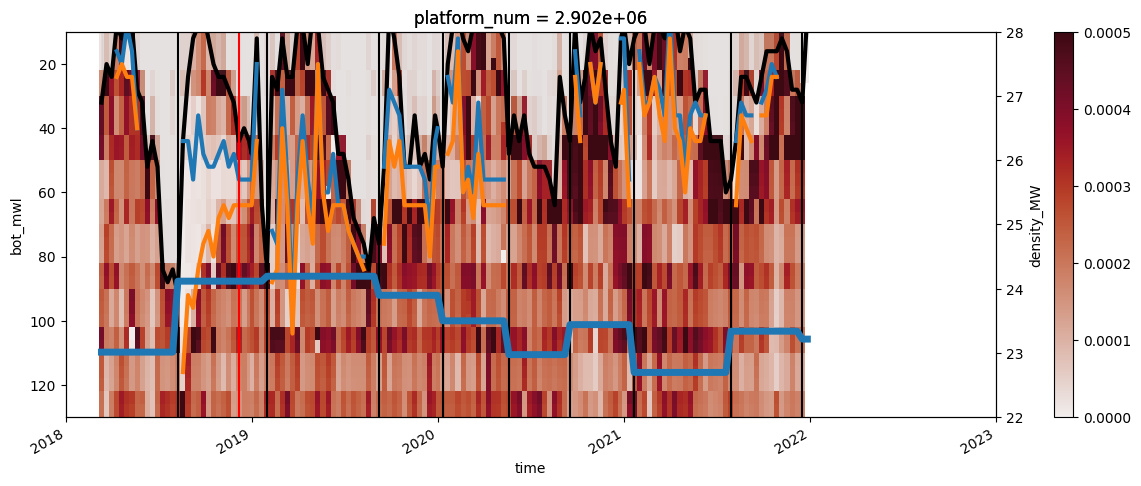

In [18]:
NNNNN=203

plt.figure(figsize=(15,5))
# df_arg.isel(platform_num=NNNNN).mixed_layer_depth.plot()

plt.pcolormesh(df_arg.time, df_arg.pressure, df_arg.isel(platform_num=NNNNN).N2, cmap=cmo.amp, vmin=0, vmax=0.0005)
# plt.pcolormesh(df_arg.time, df_arg.pressure, df_arg.isel(platform_num=NNNNN).spice, cmap=cmo.amp, vmin=4, vmax=8)
plt.colorbar()


df_arg.isel(platform_num=NNNNN).mixed_layer_depth.plot(c='k', lw=3)
plt.fill_between(df_arg.time, df_arg.isel(platform_num=NNNNN).mixed_layer_depth*0, df_arg.isel(platform_num=NNNNN).mixed_layer_depth, color='gray', alpha=0.1)


df_arg.isel(platform_num=NNNNN).top_mwl.plot(lw=3)
df_arg.isel(platform_num=NNNNN).bot_mwl.plot(lw=3)

# plt.fill_between(df_arg.time, df_arg.isel(platform_num=NNNNN).top_mwl, df_arg.isel(platform_num=NNNNN).bot_mwl)

plt.ylim(130,10)
# plt.axhline(df_arg.isel(platform_num=206).mixed_layer_depth.mean()+2*df_arg.isel(platform_num=197).mixed_layer_depth.std())
# plt.axhline(df_arg.isel(platform_num=206).mixed_layer_depth.mean()+3*df_arg.isel(platform_num=197).mixed_layer_depth.std())

# plt.axvline(df_arg.isel(platform_num=206).time.values[714], c='r')
# # df_arg.isel(platform_num=196).min_n2.ffill('time', limit=1).bfill('time', limit=1).rolling(time=3, center=True).median().plot()


# df_arg['density_MW'].isel(platform_num=197).plot()
# # df_arg['bot_mwl_rll'].isel(platform_num=196).plot()

# plt.twinx()
# df_arg['core_N2'].isel(platform_num=197).plot(c='k')
# plt.axhline(0.00005)

for i in formation_eros_date_paried(df_arg, NNNNN)[0][0]:
    plt.axvline(i, c='k')
    
for i in formation_eros_date_paried(df_arg, NNNNN)[0][1]:
    plt.axvline(i, c='r')
    
    
plt.xlim(pd.to_datetime('2018'), pd.to_datetime('2023'))  
plt.twinx()
df_arg.isel(platform_num=NNNNN).density_MW.plot(lw=5)
plt.ylim(22,28)
# df_arg.isel(platform_num=NNNNN).dens_baseml.rolling(time=3, center=True).mean().plot(lw=5)

In [ ]:
# for i in range(230):
#     _=plt.plot(df_arg.potential_density.isel(platform_num=i), df_arg.pressure)
#     plt.ylim(300,0)
#     plt.show()

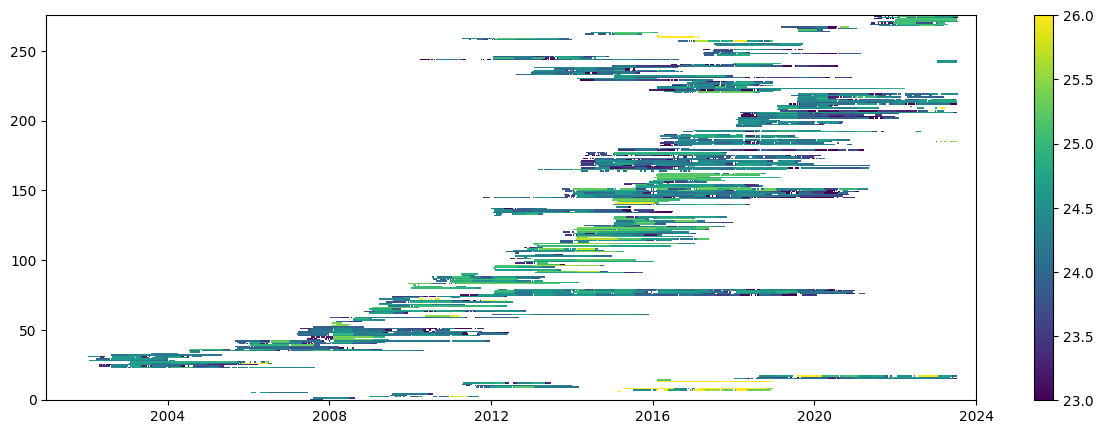

In [19]:
# cmap = cl.ListedColormap(['red', 'silver'])

plt.figure(figsize=(15,5))
plt.pcolormesh(df_arg['density_MW'].time, np.arange(0, len(df_arg['density_MW'].groupby('time.dayofyear').mean().platform_num),1), df_arg['density_MW'], vmin=23, vmax=26)
plt.colorbar()

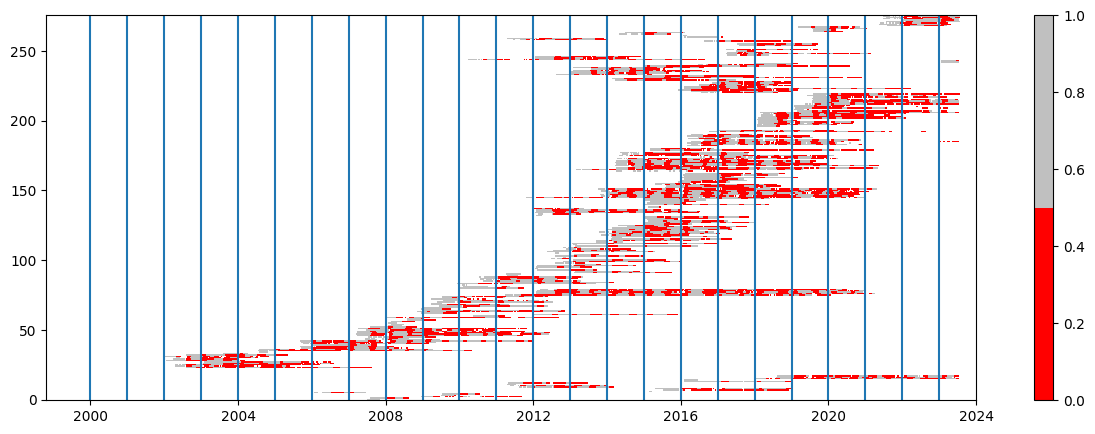

In [696]:
cmap = cl.ListedColormap(['red', 'silver'])

plt.figure(figsize=(15,5))
plt.pcolormesh(df_arg['presence_mwl'].time, np.arange(0, len(df_arg['presence_mwl'].groupby('time.dayofyear').mean().platform_num),1), df_arg['presence_mwl'], cmap=cmap)
plt.colorbar()

for i in pd.to_datetime(np.arange(np.datetime64('2000'), np.datetime64('2024'), np.timedelta64(1, "Y"))):
    plt.axvline(i)

In [342]:
# df_arg__=df_arg.where('platform_num'==(df_arg.platform_num.where(df_arg.latitude.mean('pressure').mean('time'))))

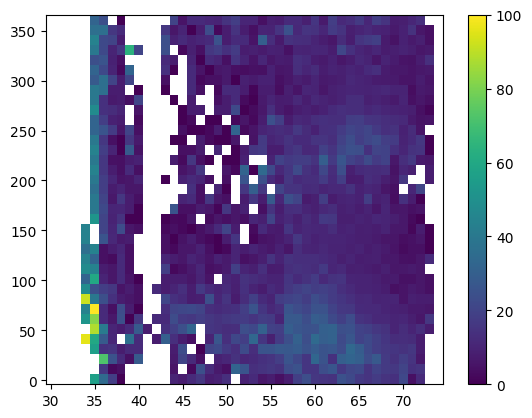

  0%|          | 0/22 [00:00<?, ?it/s]

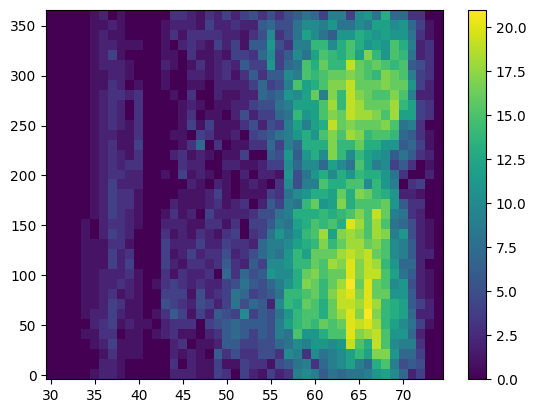

In [345]:
XX, YY=np.meshgrid(np.arange(0,len(df_arg.time)), df_arg.platform_num)
np.shape(XX)


mld_grid=sx.grid2d(df_arg.longitude.mean('pressure').values.flatten(), XX.flatten(), (df_arg.bot_mwl-df_arg.top_mwl).values.flatten(),xi=np.arange(30,75,1), yi=np.arange(0,len(df_arg.time), 1))[0]
# mld_grid=sx.grid2d(df_arg.latitude.mean('pressure').values.flatten(), XX.flatten(), df_arg.mixed_layer_depth.values.flatten(),xi=np.arange(0,30,1), yi=np.arange(0,len(df_arg.time), 1))[0]




df_per_lat= xr.Dataset(
    data_vars=dict(
        mld=(["time", "longitude"], mld_grid)
        # mixed_layer_depth=("profile_num", dff.mld.values  ), 
        # time=("profile_num", taxis ),
    ),
    coords=dict(
        longitude=np.arange(30,75,1),
        time=df_arg.time.values,
    ),)


## climatolog
plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().longitude, df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().mld)
plt.colorbar()

plt.show()

plt.pcolormesh( df_per_lat.groupby('time.dayofyear').mean().longitude,df_per_lat.groupby('time.dayofyear').mean().dayofyear,  df_per_lat.groupby('time.dayofyear').count().mld)
plt.colorbar()


mldds=df_per_lat.groupby('time.dayofyear').mean().mld.values
mldds2=df_per_lat.groupby('time.dayofyear').mean().mld.values

for i in tqdm(range(22)):
    mldds=np.concatenate([mldds2, mldds])
    
    
df_per_lat['yr_av']=(["time", "longitude"], mldds)

(50.0, 75.0)

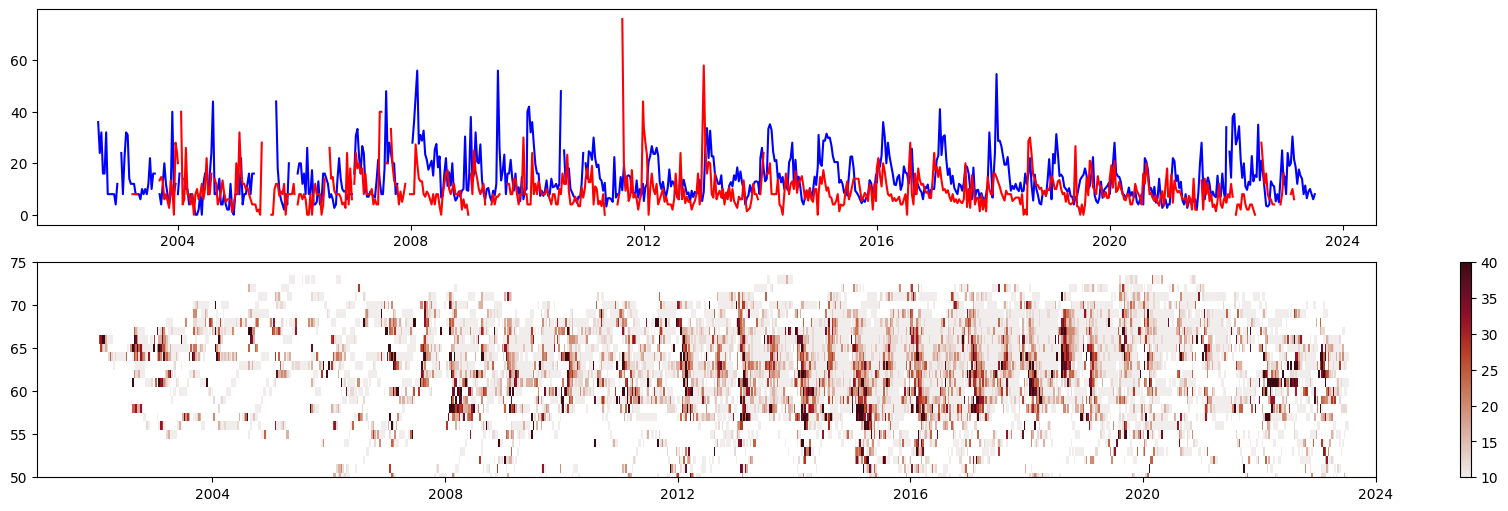

In [308]:
# anual climatoligy anomaly

plt.figure(figsize=(15,5), constrained_layout=True)

plt.subplot(211)
plt.plot(df_per_lat.time,df_per_lat.mld[:, 22:32].mean('longitude'),  c='b')
plt.plot(df_per_lat.time,df_per_lat.mld[:, 38:].mean('longitude'),  c='r')

# plt.plot(np.nanmean(df_per_lat.mld.values[:, -10:], axis=1), df_per_lat.time[::], c='r')
# plt.ylabel('MLD')
# # plt.ylim(pd.to_datetime(2000), pd.to_datetime(2024))
plt.subplot(212)
plt.pcolormesh(df_per_lat.time.values, np.arange(30,75, 1), df_per_lat.mld.T, vmin=10, vmax=40, cmap=cmo.amp)
plt.colorbar()
plt.ylim(50,75)
# plt.ylim(pd.to_datetime(2000), pd.to_datetime(2024))


(50.0, 75.0)

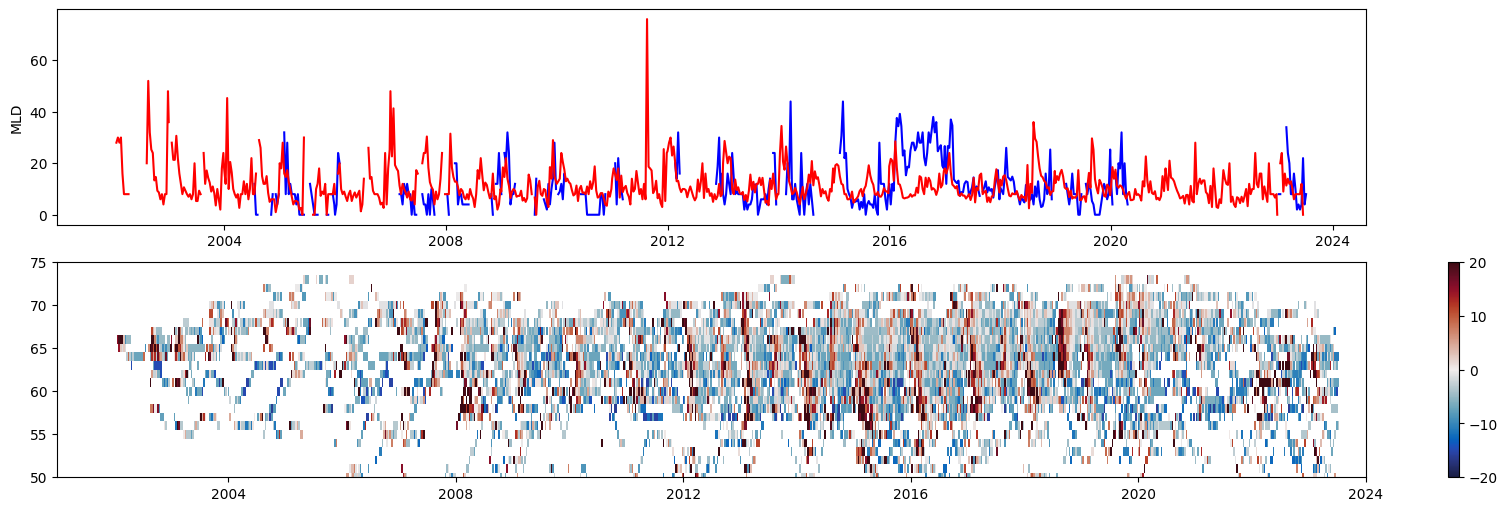

In [349]:
# mean across all time climatology anomaly --- seasoanlity


plt.figure(figsize=(15,5), constrained_layout=True)

plt.subplot(211)
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, :20], axis=1), c='b')
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, -10:], axis=1), c='r')
plt.ylabel('MLD')

plt.subplot(212)
plt.pcolormesh(df_per_lat.time.values, np.arange(30,75, 1), (df_per_lat.mld-df_per_lat.mld.mean('time')).T, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()
# plt.ylim(5,26)
plt.ylim(50,75)

# plt.axhline(20)

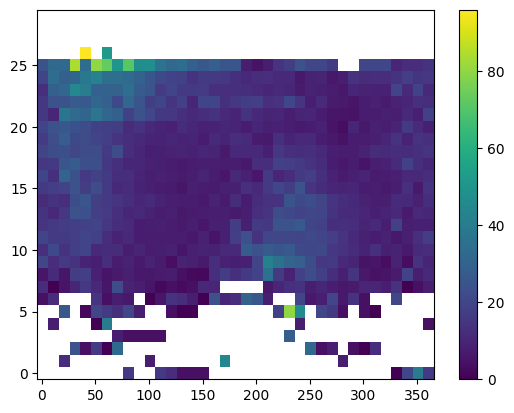

  0%|          | 0/22 [00:00<?, ?it/s]

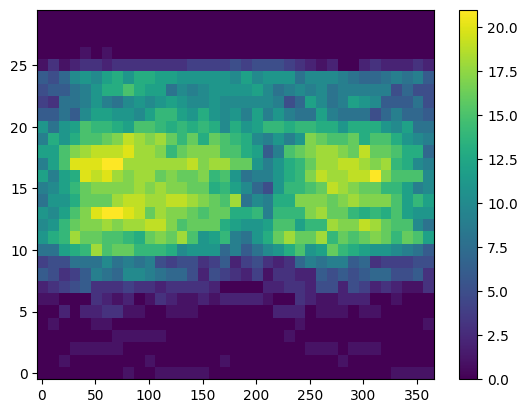

In [249]:
XX, YY=np.meshgrid(np.arange(0,len(df_arg.time)), df_arg.platform_num)
np.shape(XX)

mld_grid=sx.grid2d(df_arg.latitude.mean('pressure').values.flatten(), XX.flatten(), (df_arg.bot_mwl-df_arg.top_mwl).values.flatten(),xi=np.arange(0,30,1), yi=np.arange(0,len(df_arg.time), 1))[0]
# mld_grid=sx.grid2d(df_arg.latitude.mean('pressure').values.flatten(), XX.flatten(), df_arg.mixed_layer_depth.values.flatten(),xi=np.arange(0,30,1), yi=np.arange(0,len(df_arg.time), 1))[0]




df_per_lat= xr.Dataset(
    data_vars=dict(
        mld=(["time", "latitude"], mld_grid)
        # mixed_layer_depth=("profile_num", dff.mld.values  ), 
        # time=("profile_num", taxis ),
    ),
    coords=dict(
        latitude=np.arange(0,30,1),
        time=df_arg.time.values,
    ),)


## climatolog
plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, df_per_lat.groupby('time.dayofyear').mean().mld.T)
plt.colorbar()

plt.show()

plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, df_per_lat.groupby('time.dayofyear').count().mld.T)
plt.colorbar()


mldds=df_per_lat.groupby('time.dayofyear').mean().mld.values
mldds2=df_per_lat.groupby('time.dayofyear').mean().mld.values

for i in tqdm(range(22)):
    mldds=np.concatenate([mldds2, mldds])
    
    
df_per_lat['yr_av']=(["time", "latitude"], mldds)

(5.0, 26.0)

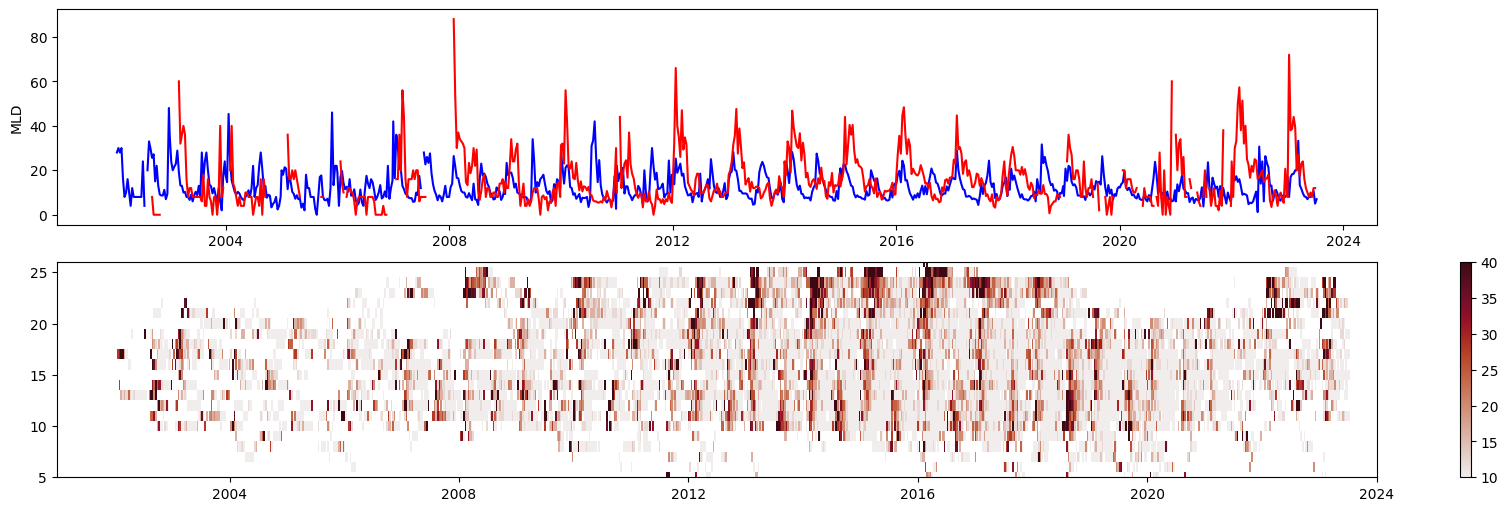

In [253]:
# anual climatoligy anomaly

plt.figure(figsize=(15,5), constrained_layout=True)

plt.subplot(211)
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, :20], axis=1), c='b')
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, -10:], axis=1), c='r')
plt.ylabel('MLD')

plt.subplot(212)
plt.pcolormesh(df_arg.time[::], np.arange(0,30,1),(df_per_lat.mld).values.T, vmin=10, vmax=40, cmap=cmo.amp)
plt.colorbar()
plt.ylim(5,26)

(5.0, 26.0)

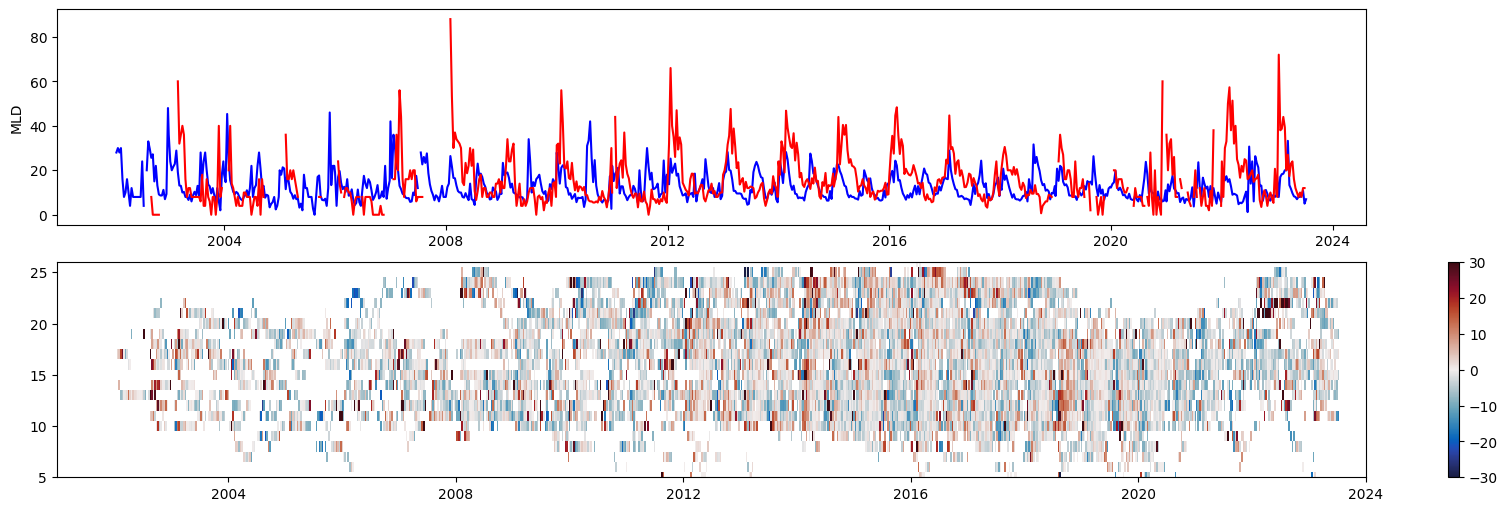

In [233]:
# anual climatoligy anomaly

plt.figure(figsize=(15,5), constrained_layout=True)

plt.subplot(211)
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, :20], axis=1), c='b')
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, -10:], axis=1), c='r')
plt.ylabel('MLD')

plt.subplot(212)
plt.pcolormesh(df_arg.time[::], np.arange(0,30,1),(df_per_lat.mld-df_per_lat.yr_av).values.T, vmin=-30, vmax=30, cmap=cmo.balance)
plt.colorbar()
plt.ylim(5,26)

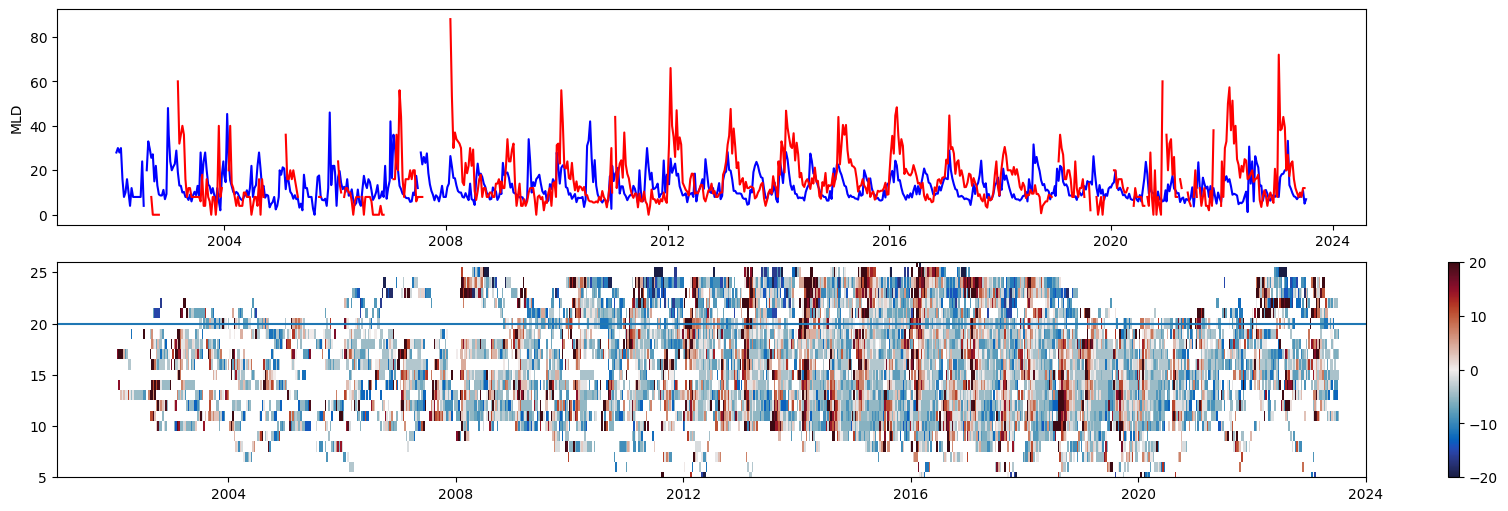

In [242]:
# mean across all time climatology anomaly --- seasoanlity


plt.figure(figsize=(15,5), constrained_layout=True)

plt.subplot(211)
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, :20], axis=1), c='b')
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, -10:], axis=1), c='r')
plt.ylabel('MLD')

plt.subplot(212)
plt.pcolormesh(df_arg.time[::], np.arange(0,30,1),(df_per_lat.mld-df_per_lat.mld.mean('time')).T, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()
plt.ylim(5,26)
plt.axhline(20)

(5.0, 26.0)

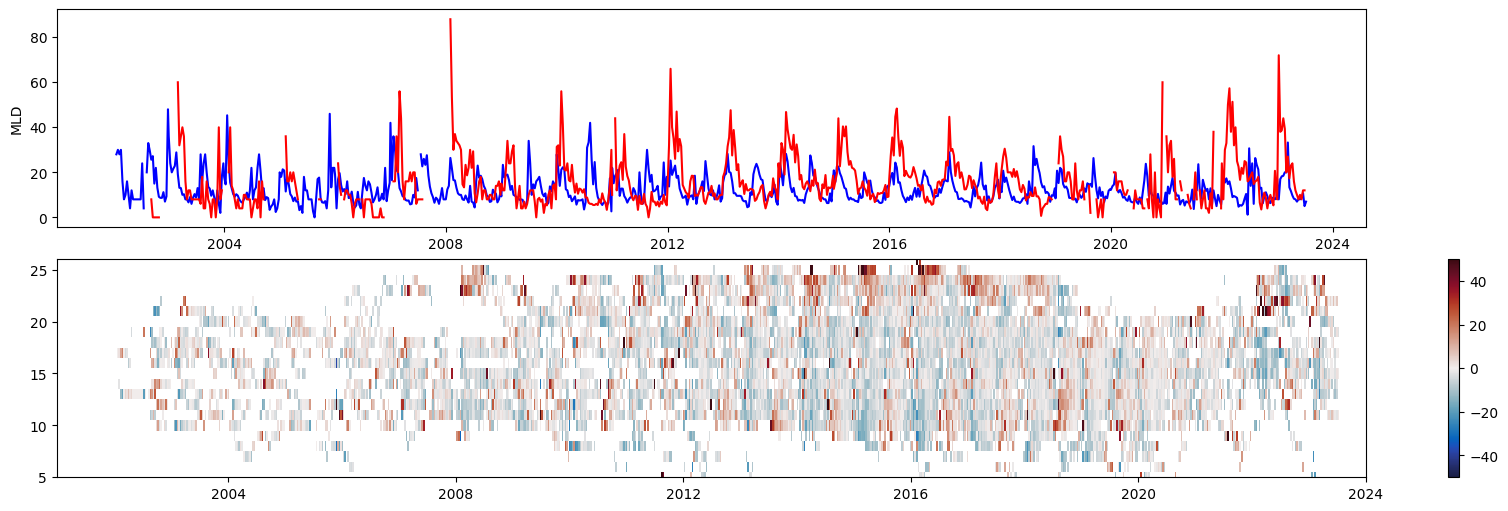

In [235]:
# mean across all latitudes climatology anomaly --- latitudinal diff?


plt.figure(figsize=(15,5), constrained_layout=True)

plt.subplot(211)
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, :20], axis=1), c='b')
plt.plot(df_arg.time[::],np.nanmean(df_per_lat.mld.values[:, -10:], axis=1), c='r')
plt.ylabel('MLD')

plt.subplot(212)
plt.pcolormesh(df_arg.time[::], np.arange(0,30,1),(df_per_lat.mld-df_per_lat.mld.mean('latitude')).T, cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()
plt.ylim(5,26)

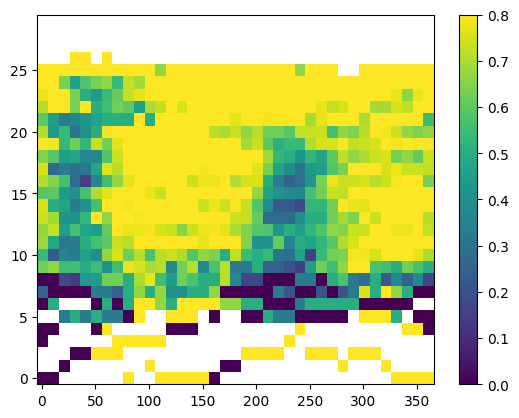

  0%|          | 0/22 [00:00<?, ?it/s]

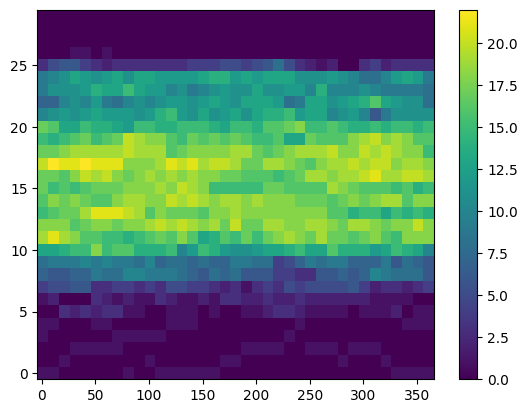

In [215]:
XX, YY=np.meshgrid(np.arange(0,len(df_arg.time)), df_arg.platform_num)
np.shape(XX)

mld_grid=sx.grid2d(df_arg.latitude.mean('pressure').values.flatten(), XX.flatten(), df_arg.presence_mwl.values.flatten(),xi=np.arange(0,30,1), yi=np.arange(0,len(df_arg.time), 1), fn='max')[0]
# plt.figure(figsize=(15,5), constrained_layout=True)

df_per_lat= xr.Dataset(
    data_vars=dict(
        mld=(["time", "latitude"], mld_grid)
        # mixed_layer_depth=("profile_num", dff.mld.values  ), 
        # time=("profile_num", taxis ),
    ),
    coords=dict(
        latitude=np.arange(0,30,1),
        time=df_arg.time.values,
    ),)


## climatolog
plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, df_per_lat.groupby('time.dayofyear').mean().mld.T, vmax=0.8)
plt.colorbar()

plt.show()

plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, df_per_lat.groupby('time.dayofyear').count().mld.T)
plt.colorbar()


mldds=df_per_lat.groupby('time.dayofyear').mean().mld.values
mldds2=df_per_lat.groupby('time.dayofyear').mean().mld.values

for i in tqdm(range(22)):
    mldds=np.concatenate([mldds2, mldds])
    
    
df_per_lat['yr_av']=(["time", "latitude"], mldds)

In [ ]:
XX, YY=np.meshgrid(np.arange(0,len(df_arg.time)), df_arg.platform_num)
np.shape(XX)

mld_grid=sx.grid2d(df_arg.latitude.mean('pressure').values.flatten(), XX.flatten(), df_arg.presence_mwl.values.flatten(),xi=np.arange(0,30,1), yi=np.arange(0,len(df_arg.time), 1), fn='max')[0]
# plt.figure(figsize=(15,5), constrained_layout=True)

df_per_lat= xr.Dataset(
    data_vars=dict(
        mld=(["time", "latitude"], mld_grid)
        # mixed_layer_depth=("profile_num", dff.mld.values  ), 
        # time=("profile_num", taxis ),
    ),
    coords=dict(
        latitude=np.arange(0,30,1),
        time=df_arg.time.values,
    ),)


## climatolog
plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, df_per_lat.groupby('time.dayofyear').mean().mld.T, vmax=0.8)
plt.colorbar()

plt.show()

plt.pcolormesh(df_per_lat.groupby('time.dayofyear').mean().dayofyear, df_per_lat.groupby('time.dayofyear').mean().latitude, df_per_lat.groupby('time.dayofyear').count().mld.T)
plt.colorbar()


mldds=df_per_lat.groupby('time.dayofyear').mean().mld.values
mldds2=df_per_lat.groupby('time.dayofyear').mean().mld.values

for i in tqdm(range(22)):
    mldds=np.concatenate([mldds2, mldds])
    
    
df_per_lat['yr_av']=(["time", "latitude"], mldds)

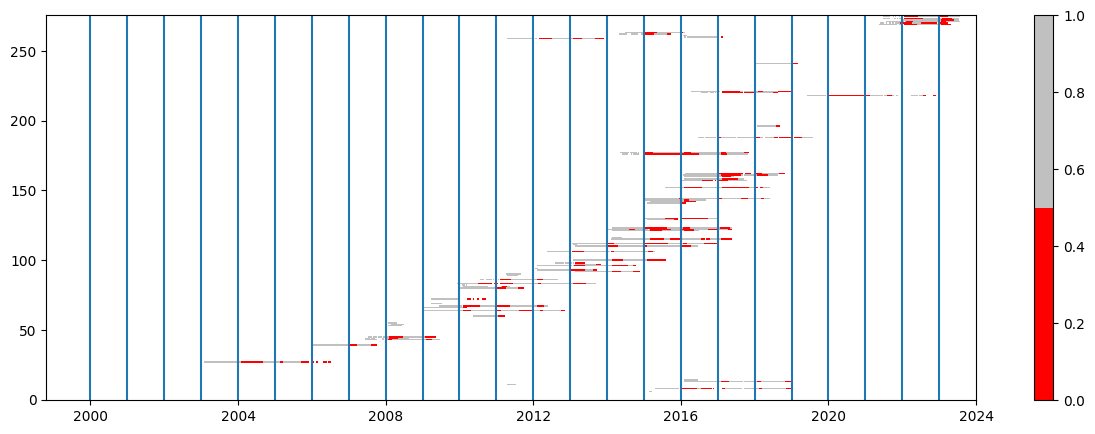

In [25]:
cmap = cl.ListedColormap(['red', 'silver'])

plt.figure(figsize=(15,5))
plt.pcolormesh(df_arg['presence_mwl'].time, np.arange(0, len(df_arg['presence_mwl'].groupby('time.dayofyear').mean().platform_num),1), df_arg.where(df_arg['latitude'].mean('pressure').mean('time')>20)['presence_mwl'], cmap=cmap)
plt.colorbar()
for i in pd.to_datetime(np.arange(np.datetime64('2000'), np.datetime64('2024'), np.timedelta64(1, "Y"))):
    plt.axvline(i)

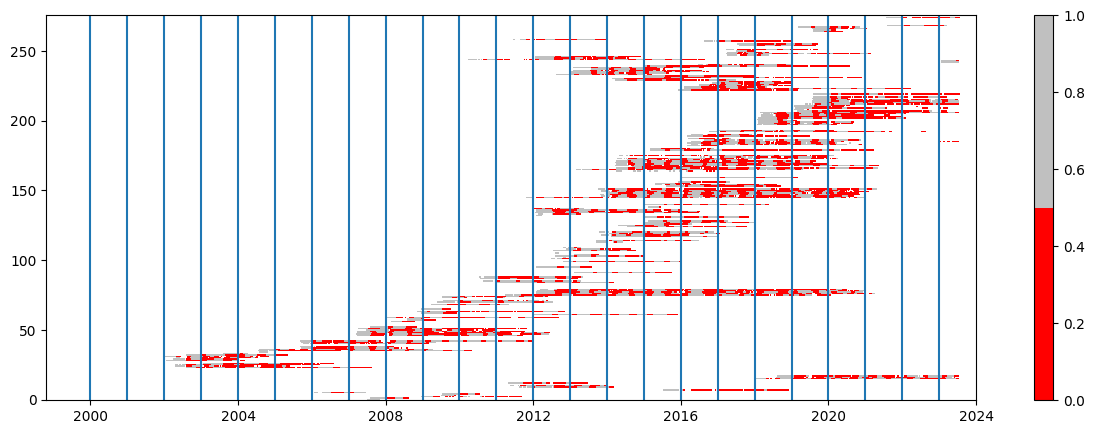

In [24]:
cmap = cl.ListedColormap(['red', 'silver'])

plt.figure(figsize=(15,5))
plt.pcolormesh(df_arg['presence_mwl'].time, np.arange(0, len(df_arg['presence_mwl'].groupby('time.dayofyear').mean().platform_num),1), df_arg.where(df_arg['latitude'].mean('pressure').mean('time')<20)['presence_mwl'], cmap=cmap)
plt.colorbar()
for i in pd.to_datetime(np.arange(np.datetime64('2000'), np.datetime64('2024'), np.timedelta64(1, "Y"))):
    plt.axvline(i)

In [600]:
ms_pres = df_arg.groupby('time.year')[2021].presence_mwl.values
ms_pres[ms_pres==0]=np.nan

(200.0, 220.0)

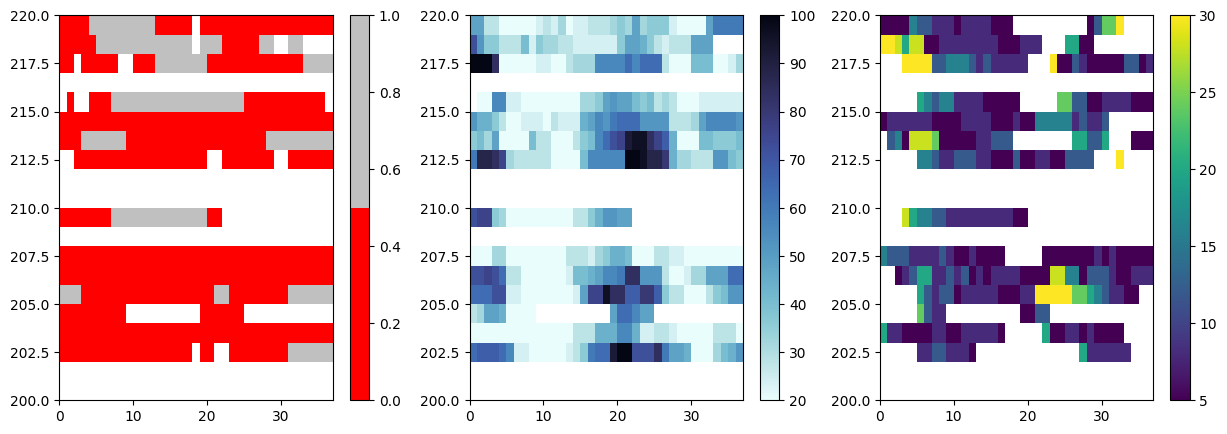

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(df_arg.groupby('time.year')[2021].presence_mwl, cmap=cmap)
plt.colorbar()
plt.ylim(200,220)

plt.subplot(132)
plt.pcolormesh(df_arg.groupby('time.year')[2021].mixed_layer_depth_rll, vmin=20, vmax=100, cmap=cmo.ice_r)
plt.colorbar()
plt.ylim(200,220)

plt.subplot(133)
# plt.pcolormesh(df_arg.groupby('time.year')[2020].latitude.mean('pressure'), vmax=20)
plt.pcolormesh((df_arg.groupby('time.year')[2021].bot_mwl_rll- df_arg.groupby('time.year')[2021].top_mwl_rll), vmin=5, vmax=30)
# plt.pcolormesh(df_arg.groupby('time.year')[2020].core_cons_temp)
plt.colorbar()

plt.ylim(200,220)

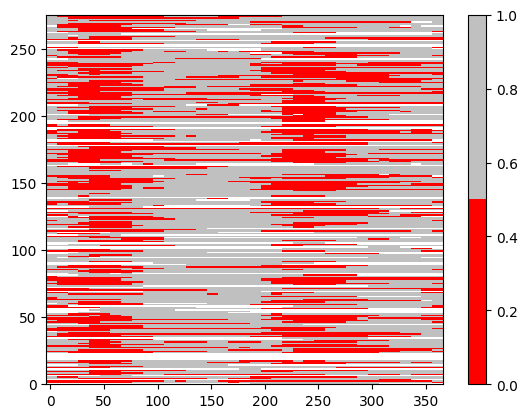

In [610]:
cmap = cl.ListedColormap(['red', 'silver'])
plt.pcolormesh(df_arg['presence_mwl'].groupby('time.dayofyear').mean().dayofyear, np.arange(0, len(df_arg['presence_mwl'].groupby('time.dayofyear').mean().platform_num),1), df_arg['presence_mwl'].groupby('time.dayofyear').mean(), cmap=cmap)
plt.colorbar()

In [411]:
# df_n=df_arg.sel(platform_num=df_arg.platform_num[msk_north])
# df_s=df_arg.sel(platform_num=df_arg.platform_num[msk_south])

In [17]:
df_nn=df_arg.stack(profile_num=("time", "platform_num")).reset_index('profile_num').reset_coords(names="platform_num")

In [18]:
df_nn=df_nn.assign_coords(profile_num=("profile_num", df_nn.profile_num.values))

In [19]:
df_nn['lat_pp']=df_nn.latitude.mean('pressure')
df_nn['lon_pp']=df_nn.longitude.mean('pressure')

In [70]:
formation_eros_date_paried(df_arg, i)[0][1]

array(['2022-06-10T00:00:00.000000000', '2022-06-10T00:00:00.000000000',
       '2023-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [611]:
lat_, lon_, time_start, time_end, length_=[], [], [], [], []

time_start=np.array([]).astype('datetime64[ns]')
time_end=np.array([]).astype('datetime64[ns]')

length_=np.array([]).astype('timedelta64[D]')

for i in tqdm(range(len(df_arg.platform_num.values))):
    lat_=np.concatenate([lat_, df_arg.latitude.isel(platform_num=i).sel(time=pd.DataFrame(formation_eros_date_paried(df_arg, i)[0][0]).dropna()[0].to_numpy()).mean('pressure').values])
    lon_=np.concatenate([lon_, df_arg.longitude.isel(platform_num=i).sel(time=pd.DataFrame(formation_eros_date_paried(df_arg, i)[0][0]).dropna()[0].to_numpy()).mean('pressure').values])
    time_start=np.concatenate([time_start, formation_eros_date_paried(df_arg, i)[0][0]])  
    time_end=np.concatenate([time_end, formation_eros_date_paried(df_arg, i)[0][1]])    
    
    length_=np.concatenate([length_, formation_eros_date_paried(df_arg, i)[1]])

  0%|          | 0/276 [00:00<?, ?it/s]

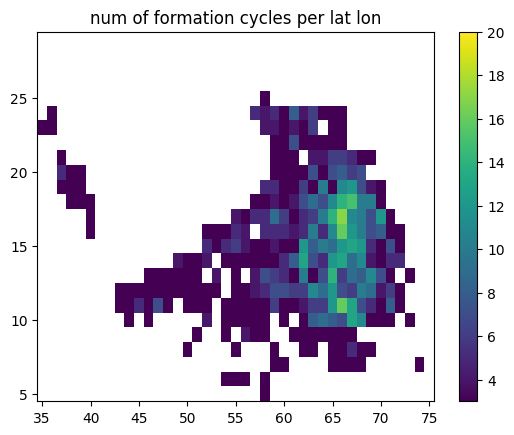

In [612]:
lattarr=np.arange(5,30,1)
lonnarr=np.arange(35,76,1)

count_st, latttt, lonnnn=sx.grid2d(lon_, lat_, time_start, xi=lonnarr, yi=lattarr, fn='count')

plt.title('num of formation cycles per lat lon')
plt.pcolormesh(lonnarr, lattarr, count_st, vmin=3, vmax=20)
plt.colorbar()

Text(0.5, 0, 'day of year')

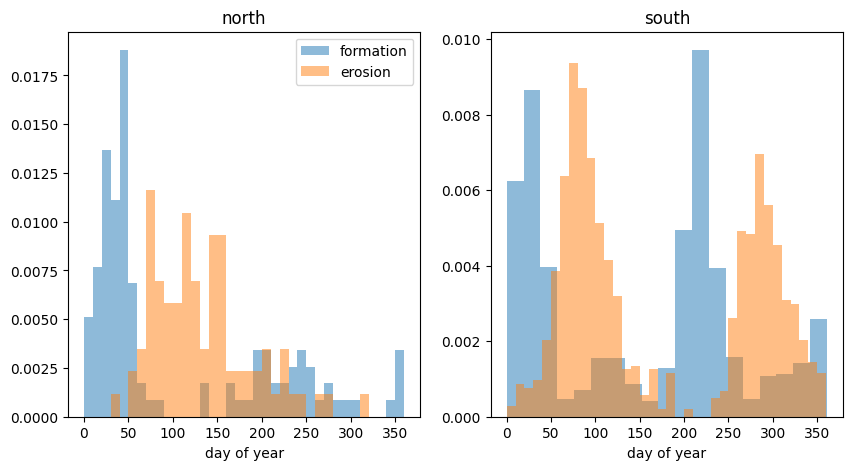

In [613]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('north')
_=plt.hist(pd.to_datetime(time_start[lat_>21]).dayofyear, bins=np.arange(0,365,10), alpha=0.5, label='formation', density=True)
# _=plt.axvline(np.nanmean(pd.to_datetime(time_start[lat_>20]).dayofyear), c='b')

_=plt.hist(pd.to_datetime(time_end[lat_>21]).dayofyear, bins=np.arange(0,365,10), alpha=0.5, label='erosion', density=True)
# _=plt.axvline(np.nanmean(pd.to_datetime(time_end[lat_>20]).dayofyear), c='orange')

plt.xlabel('day of year')
plt.legend()
plt.subplot(122)
plt.title('south')

_=plt.hist(pd.to_datetime(time_start[lat_<21]).dayofyear, bins=np.arange(0,365,19), alpha=0.5, label='formation', density=True)
_=plt.hist(pd.to_datetime(time_end[lat_<21]).dayofyear, bins=np.arange(0,365,10), alpha=0.5, label='erosion', density=True)

plt.xlabel('day of year')
# plt.legend()

In [42]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

def analyze_distribution(data):
    # Perform kernel density estimation
    kde = gaussian_kde(data)
    
    # Evaluate the KDE on a grid
    x_grid = np.linspace(min(data), max(data), 1000)
    y_kde = kde(x_grid)
    
    threshold = np.mean(y_kde)

    # Find peaks in the KDE
    peaks, _ = find_peaks(y_kde, height=threshold)
    
    # Plot the distribution and highlight peaks
    plt.plot(x_grid, y_kde, label='Kernel Density Estimation')
    plt.scatter(x_grid[peaks], y_kde[peaks], color='red', marker='x', label='Peaks')
    plt.legend()
    plt.title('Distribution Analysis')
    plt.xlabel('Data')
    plt.ylabel('Density')
    # plt.show()
    
    # Determine the number of peaks
    num_peaks = len(peaks)
    
    # # Classify the distribution based on the number of peaks
    # if num_peaks == 1:
    #     return "Unimodal"
    # elif num_peaks == 2:
    #     return "Bimodal"
    # else:
    #     return "Mixed"
    
    # Calculate the separation and width between modes for bimodal distributions
    separation = None
    widths = None
    if num_peaks == 2:
        separation = np.abs(x_grid[peaks[0]] - x_grid[peaks[1]])
        widths = [kde.covariance_factor() * np.std(data) for peak in peaks]
    
    # Classify the distribution based on the number of peaks, separation, and widths
    if num_peaks == 1:
        return f"Unimodal (Width: {np.std(data):.2f})"
    elif num_peaks == 2 and separation is not None:
        if separation < 2.0:  # Adjust the threshold for what you consider "mixed"
            return f"Bimodal (Mixed, Separation: {separation:.2f}, Widths: {widths})"
        else:
            return f"Bimodal (Clear, Separation: {separation:.2f}, Widths: {widths})"
    else:
        return "Mixed"


The distribution is Bimodal (Clear, Separation: 187.75, Widths: [24.76253412267798, 24.76253412267798]).
The distribution is Unimodal (Width: 108.16).


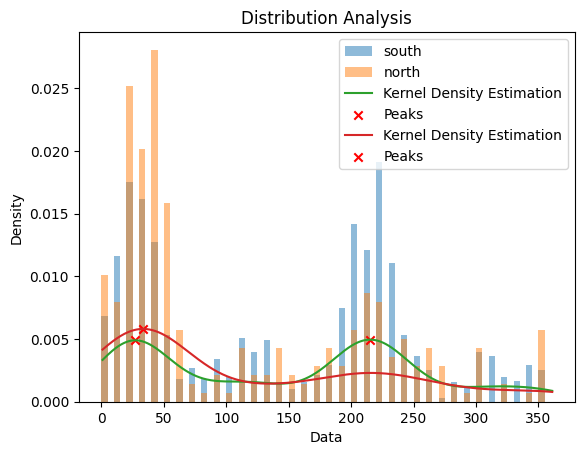

In [43]:
_=plt.hist(pd.to_datetime(time_start[lat_<20]).dayofyear, bins=np.arange(0,365,5), alpha=0.5, label='south', density=True)
_=plt.hist(pd.to_datetime(time_start[lat_>20]).dayofyear, bins=np.arange(0,365,5), alpha=0.5, label='north', density=True)

# Example usage
data = pd.to_datetime(time_start[lat_<20]).dayofyear  # Replace this with your dataset
result = analyze_distribution(data)
print(f"The distribution is {result}.")


data = pd.to_datetime(time_start[lat_>20]).dayofyear  # Replace this with your dataset
result = analyze_distribution(data)
print(f"The distribution is {result}.")

In [19]:
length_=length_.astype(float)
length_[length_==-9223372036854775808]=np.nan
length_[length_>100]=np.nan
length_[length_<30]=np.nan

In [20]:
msk_1=((pd.to_datetime(time_start).month<5) | (pd.to_datetime(time_start).month>=10))
msk_2=((pd.to_datetime(time_start).month>=5) & (pd.to_datetime(time_start).month<10))

(10.0, 26.0)

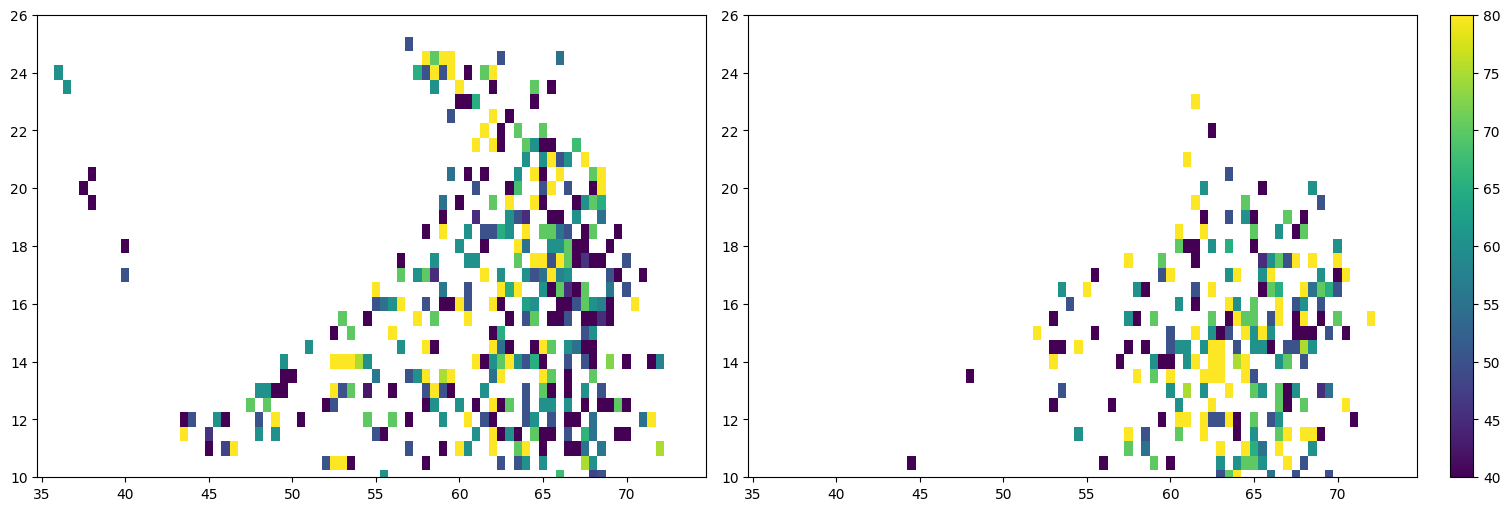

In [30]:
lattarr=np.arange(5,30,0.5)
lonnarr=np.arange(35,75,0.5)

plt.figure(figsize=(15,5), constrained_layout=True)
plt.subplot(121)
plt.pcolormesh(lonnarr,  lattarr, sx.grid2d(lon_[msk_1], lat_[msk_1], length_[msk_1], xi=lonnarr,  yi=lattarr, fn='median')[0], vmin=40, vmax=80)
# plt.colorbar()
plt.ylim(10,26)

plt.subplot(122)

plt.pcolormesh(lonnarr,  lattarr, sx.grid2d(lon_[msk_2], lat_[msk_2], length_[msk_2], xi=lonnarr,  yi=lattarr, fn='median')[0], vmin=40, vmax=80)
plt.colorbar()
plt.ylim(10,26)

(10.0, 26.0)

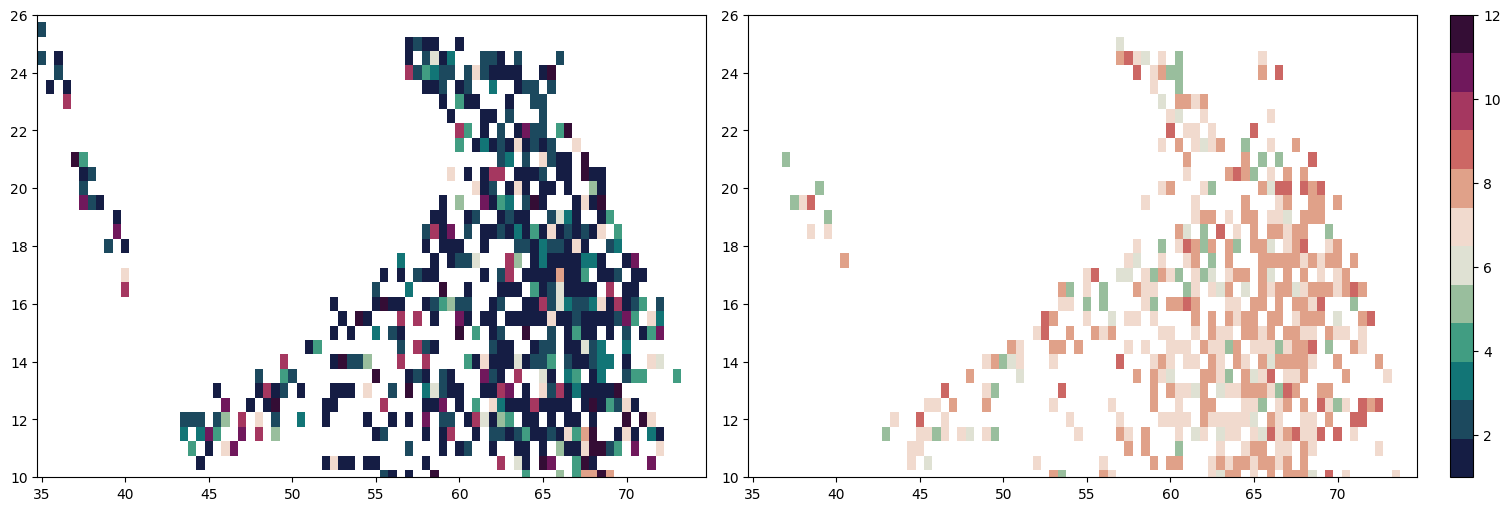

In [27]:
lattarr=np.arange(5,30,0.5)
lonnarr=np.arange(35,75,0.5)

boundaries = np.arange(0, .7, .1)
# create list of 7(!) colors from colormap
cmap_reds = plt.cm.get_cmap('cmo.curl',12)
colors = list(cmap_reds(np.arange(12)))
#replace first color with white
# colors[0] = "white"
cmap = cl.ListedColormap(colors[:], "")

plt.figure(figsize=(15,5), constrained_layout=True)
plt.subplot(121)
plt.pcolormesh(lonnarr,  lattarr, sx.grid2d(lon_[msk_1], lat_[msk_1], pd.to_datetime(time_start).month[msk_1], xi=lonnarr,  yi=lattarr, fn='median')[0], vmin=1, vmax=12,cmap=cmap)
# plt.colorbar()
plt.ylim(10,26)

plt.subplot(122)
plt.pcolormesh(lonnarr,  lattarr, sx.grid2d(lon_[msk_2], lat_[msk_2], pd.to_datetime(time_start).month[msk_2], xi=lonnarr,  yi=lattarr, fn='median')[0], vmin=1, vmax=12, cmap=cmap)
plt.colorbar()
plt.ylim(10,26)

In [ ]:
# df_formation = xr.Dataset(
#     data_vars=dict(
#         potential_density=(["pressure", "profile_num"], grid_pp(dff, 'potential_density')[0]),
#         abs_salinity=(["pressure", "profile_num"], grid_pp(dff, 'abs_salinity')[0]),
#         cons_temp=(["pressure", "profile_num"], grid_pp(dff, 'cons_temp')[0]),
        
#         N2=(["pressure", "profile_num"], grid_pp(dff, 'N2')[0]),
#         PV=(["pressure", "profile_num"], grid_pp(dff,'PV')[0]),
        
#         oxygen_concentration=(["pressure", "profile_num"], grid_pp(dff, 'oxygen_concentration')[0]),
#         # chlorophyll=(["pressure", "time"], grid_pp(dff, 'chlorophyll')[0]),
#         # downwelling_PAR=(["pressure", "time"], grid_pp(dff, 'downwelling_PAR')[0]),
        
#         aou=(["pressure", "profile_num"], grid_pp(dff, 'aou')[0]),
#         latitude=(["pressure", "profile_num"], grid_pp(dff, 'latitude')[0]),
#         longitude=(["pressure", "profile_num"], grid_pp(dff, 'longitude')[0]),
        
#         # mixed_layer_depth=("profile_num", dff.mld.values  ), 
#         time=("profile_num", taxis ),
#     ),
#     coords=dict(
#         pressure=yaxis,
#         platform_num=df_arg.platform_num.values,
#     ),)


In [157]:
GS=0.5
lat_min = (-5)
lat_max = (30)
lat = np.arange(lat_min,lat_max+GS,GS)

lon_min = 30
lon_max = 80
lon = np.arange(lon_min,lon_max+GS,GS)
    
def grid_lat_4d(dsgpd_ln,gs=GS):
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('lat_pp',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True,dim='profile_num') #.count(dim='profile_num')#m
    
def grid_lon_4d(dsgpd_t,gs=GS):
    # define lon min and max resp

    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)
    
    return dsgpd_t.groupby_bins('lon_pp',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_4d)
    
def grid_var_4d(dsvar,clim='month',gs=GS):
    """for gridding spatially in 3D and in time (4D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_4d)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_4d)
    return var

In [158]:
regirded_df= grid_var_4d(df_nn)  

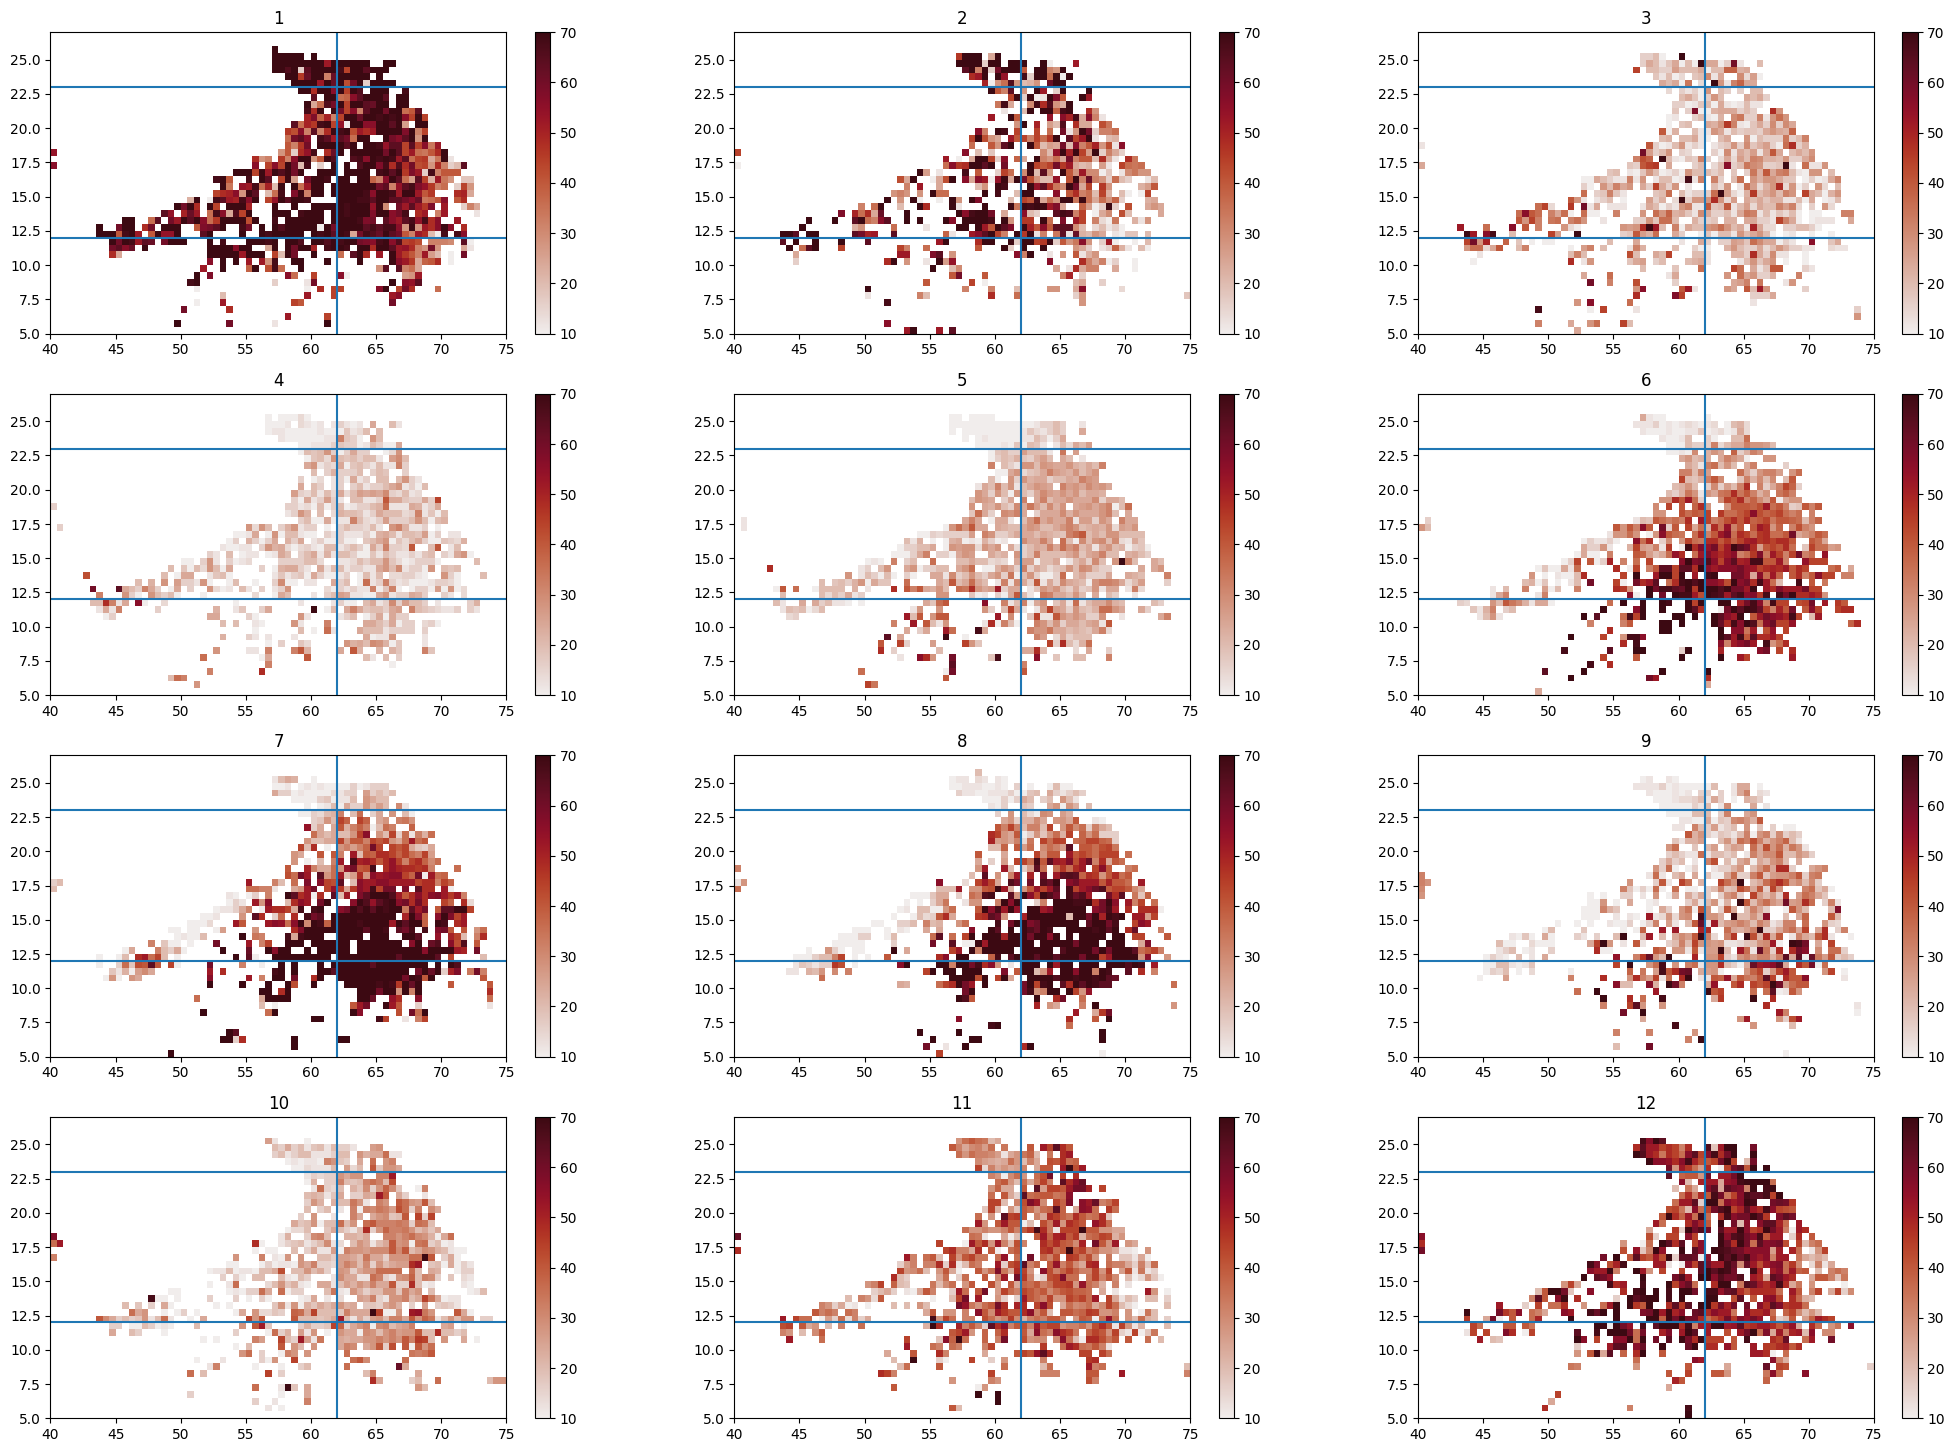

In [173]:
fig, ax=plt.subplots(4,3, figsize=(25,18))
ax=ax.flatten()

for i in range(12):
    axi=ax[i]
    axi.set_title(str(i+1))
    cb=axi.pcolormesh(lon, lat, regirded_df.isel(month=i).mixed_layer_depth.T, vmin=10, vmax=70, cmap=cmo.amp)
    plt.colorbar(cb)
    axi.set_ylim(5,27)
    axi.set_xlim(40,75)
    axi.axvline(62)
    axi.axhline(23)
    axi.axhline(12)
    
    # cmap = cl.ListedColormap(['white', [ 1. , 1. , 1. , 0.0]])
    # axi.pcolormesh(lon, lat,(regirded_df.isel(month=i).bot_mwl.T-regirded_df.isel(month=i).top_mwl.T)<10, cmap=cmap)
    # plt.show()

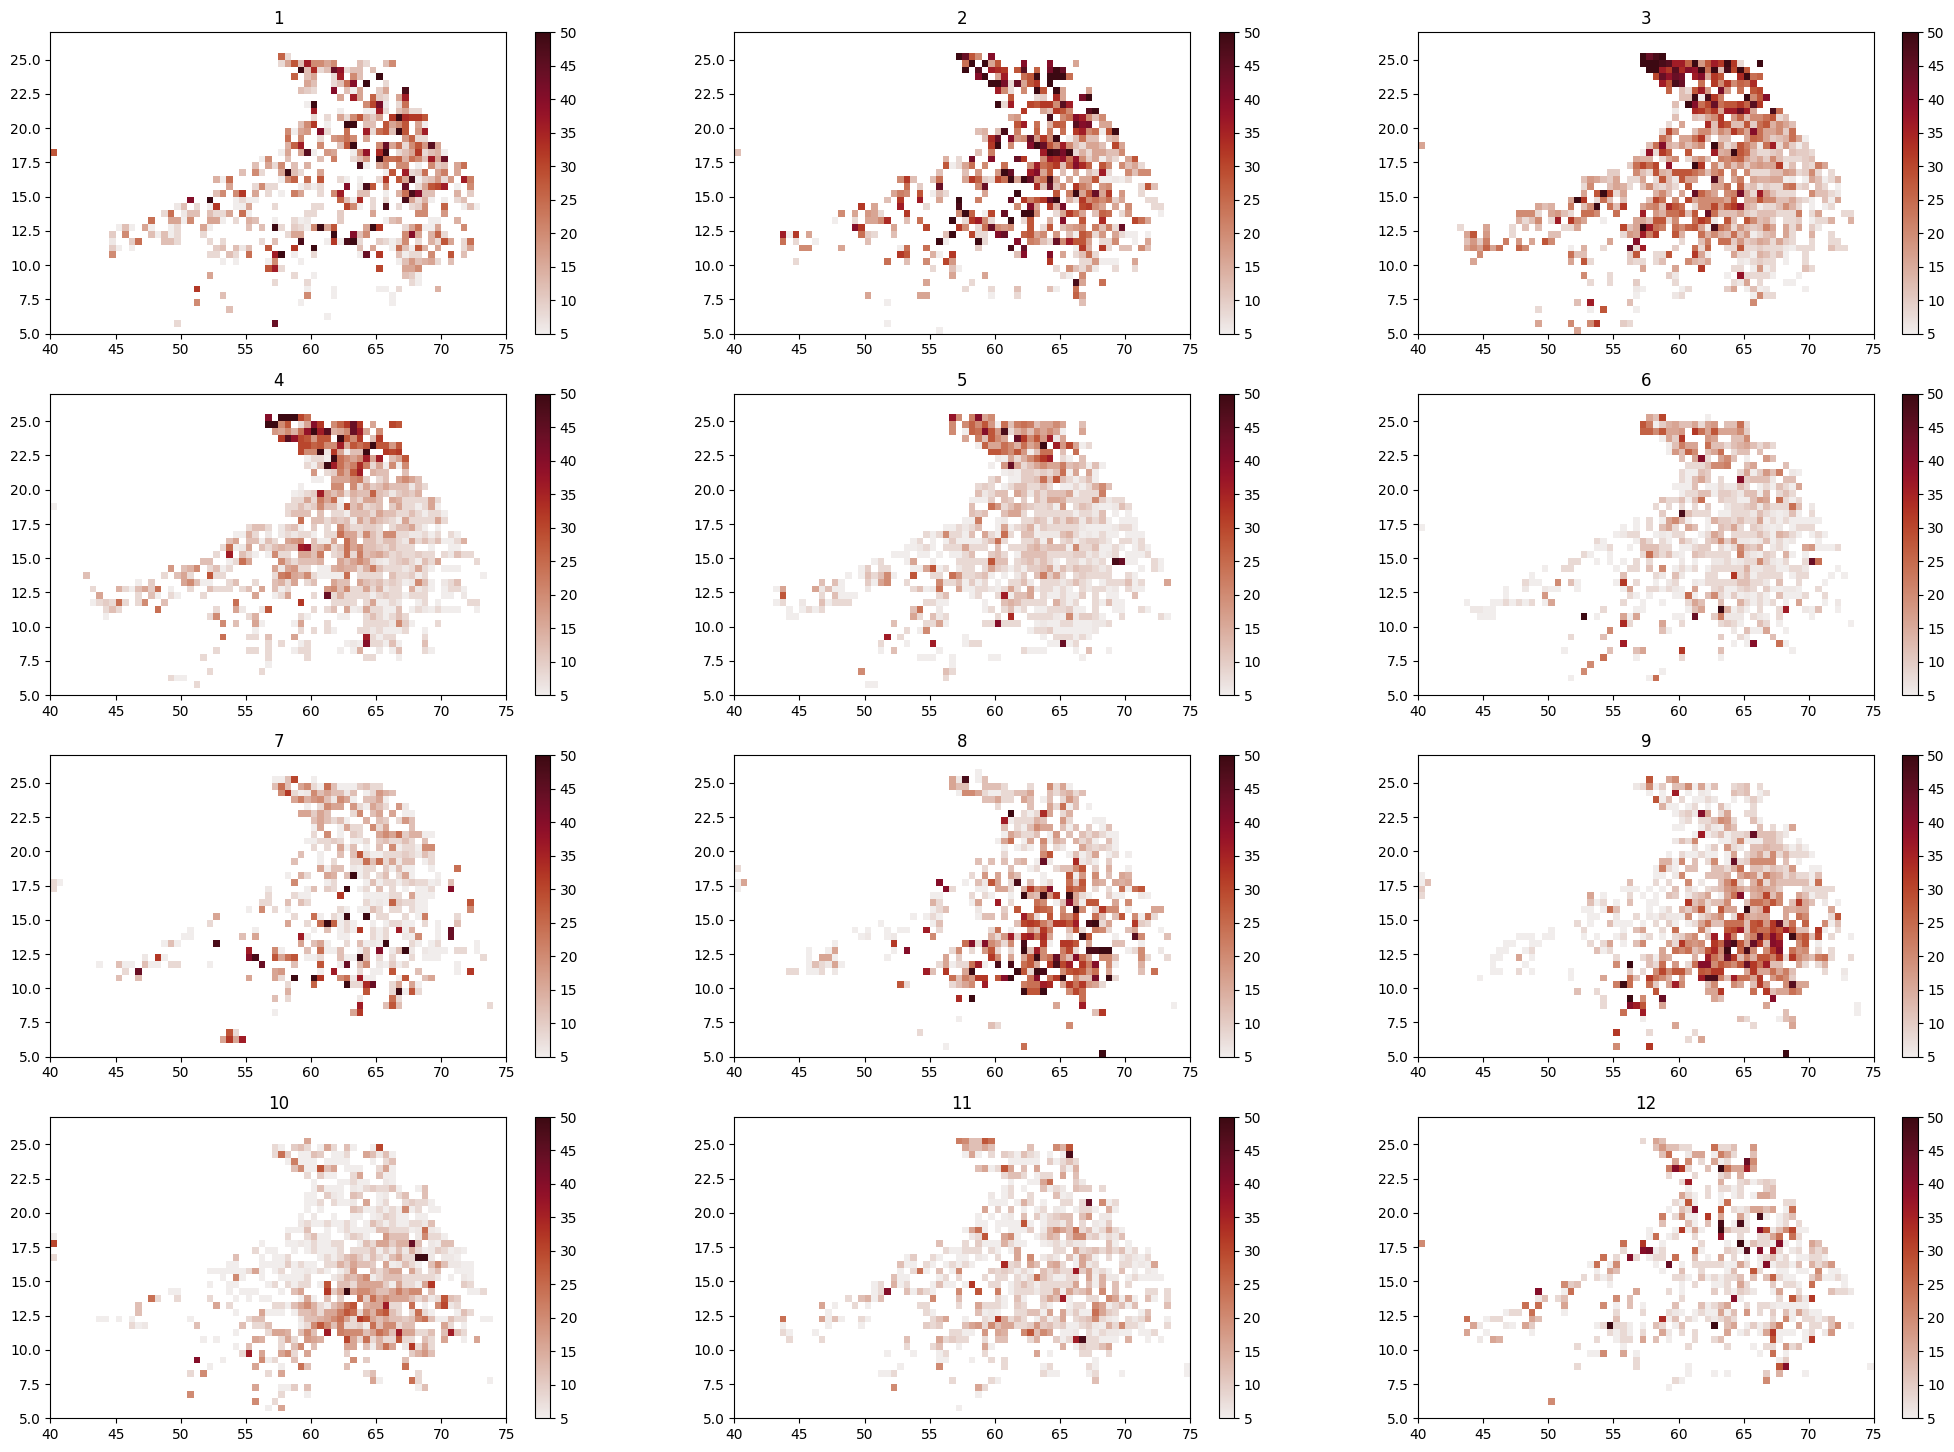

In [167]:
fig, ax=plt.subplots(4,3, figsize=(25,18))
ax=ax.flatten()

for i in range(12):
    axi=ax[i]
    axi.set_title(str(i+1))
    cb=axi.pcolormesh(lon, lat, regirded_df.isel(month=i).bot_mwl.T-regirded_df.isel(month=i).top_mwl.T, vmin=5, vmax=50, cmap=cmo.amp)
    plt.colorbar(cb)
    axi.set_ylim(5,27)
    axi.set_xlim(40,75)
    # plt.show()

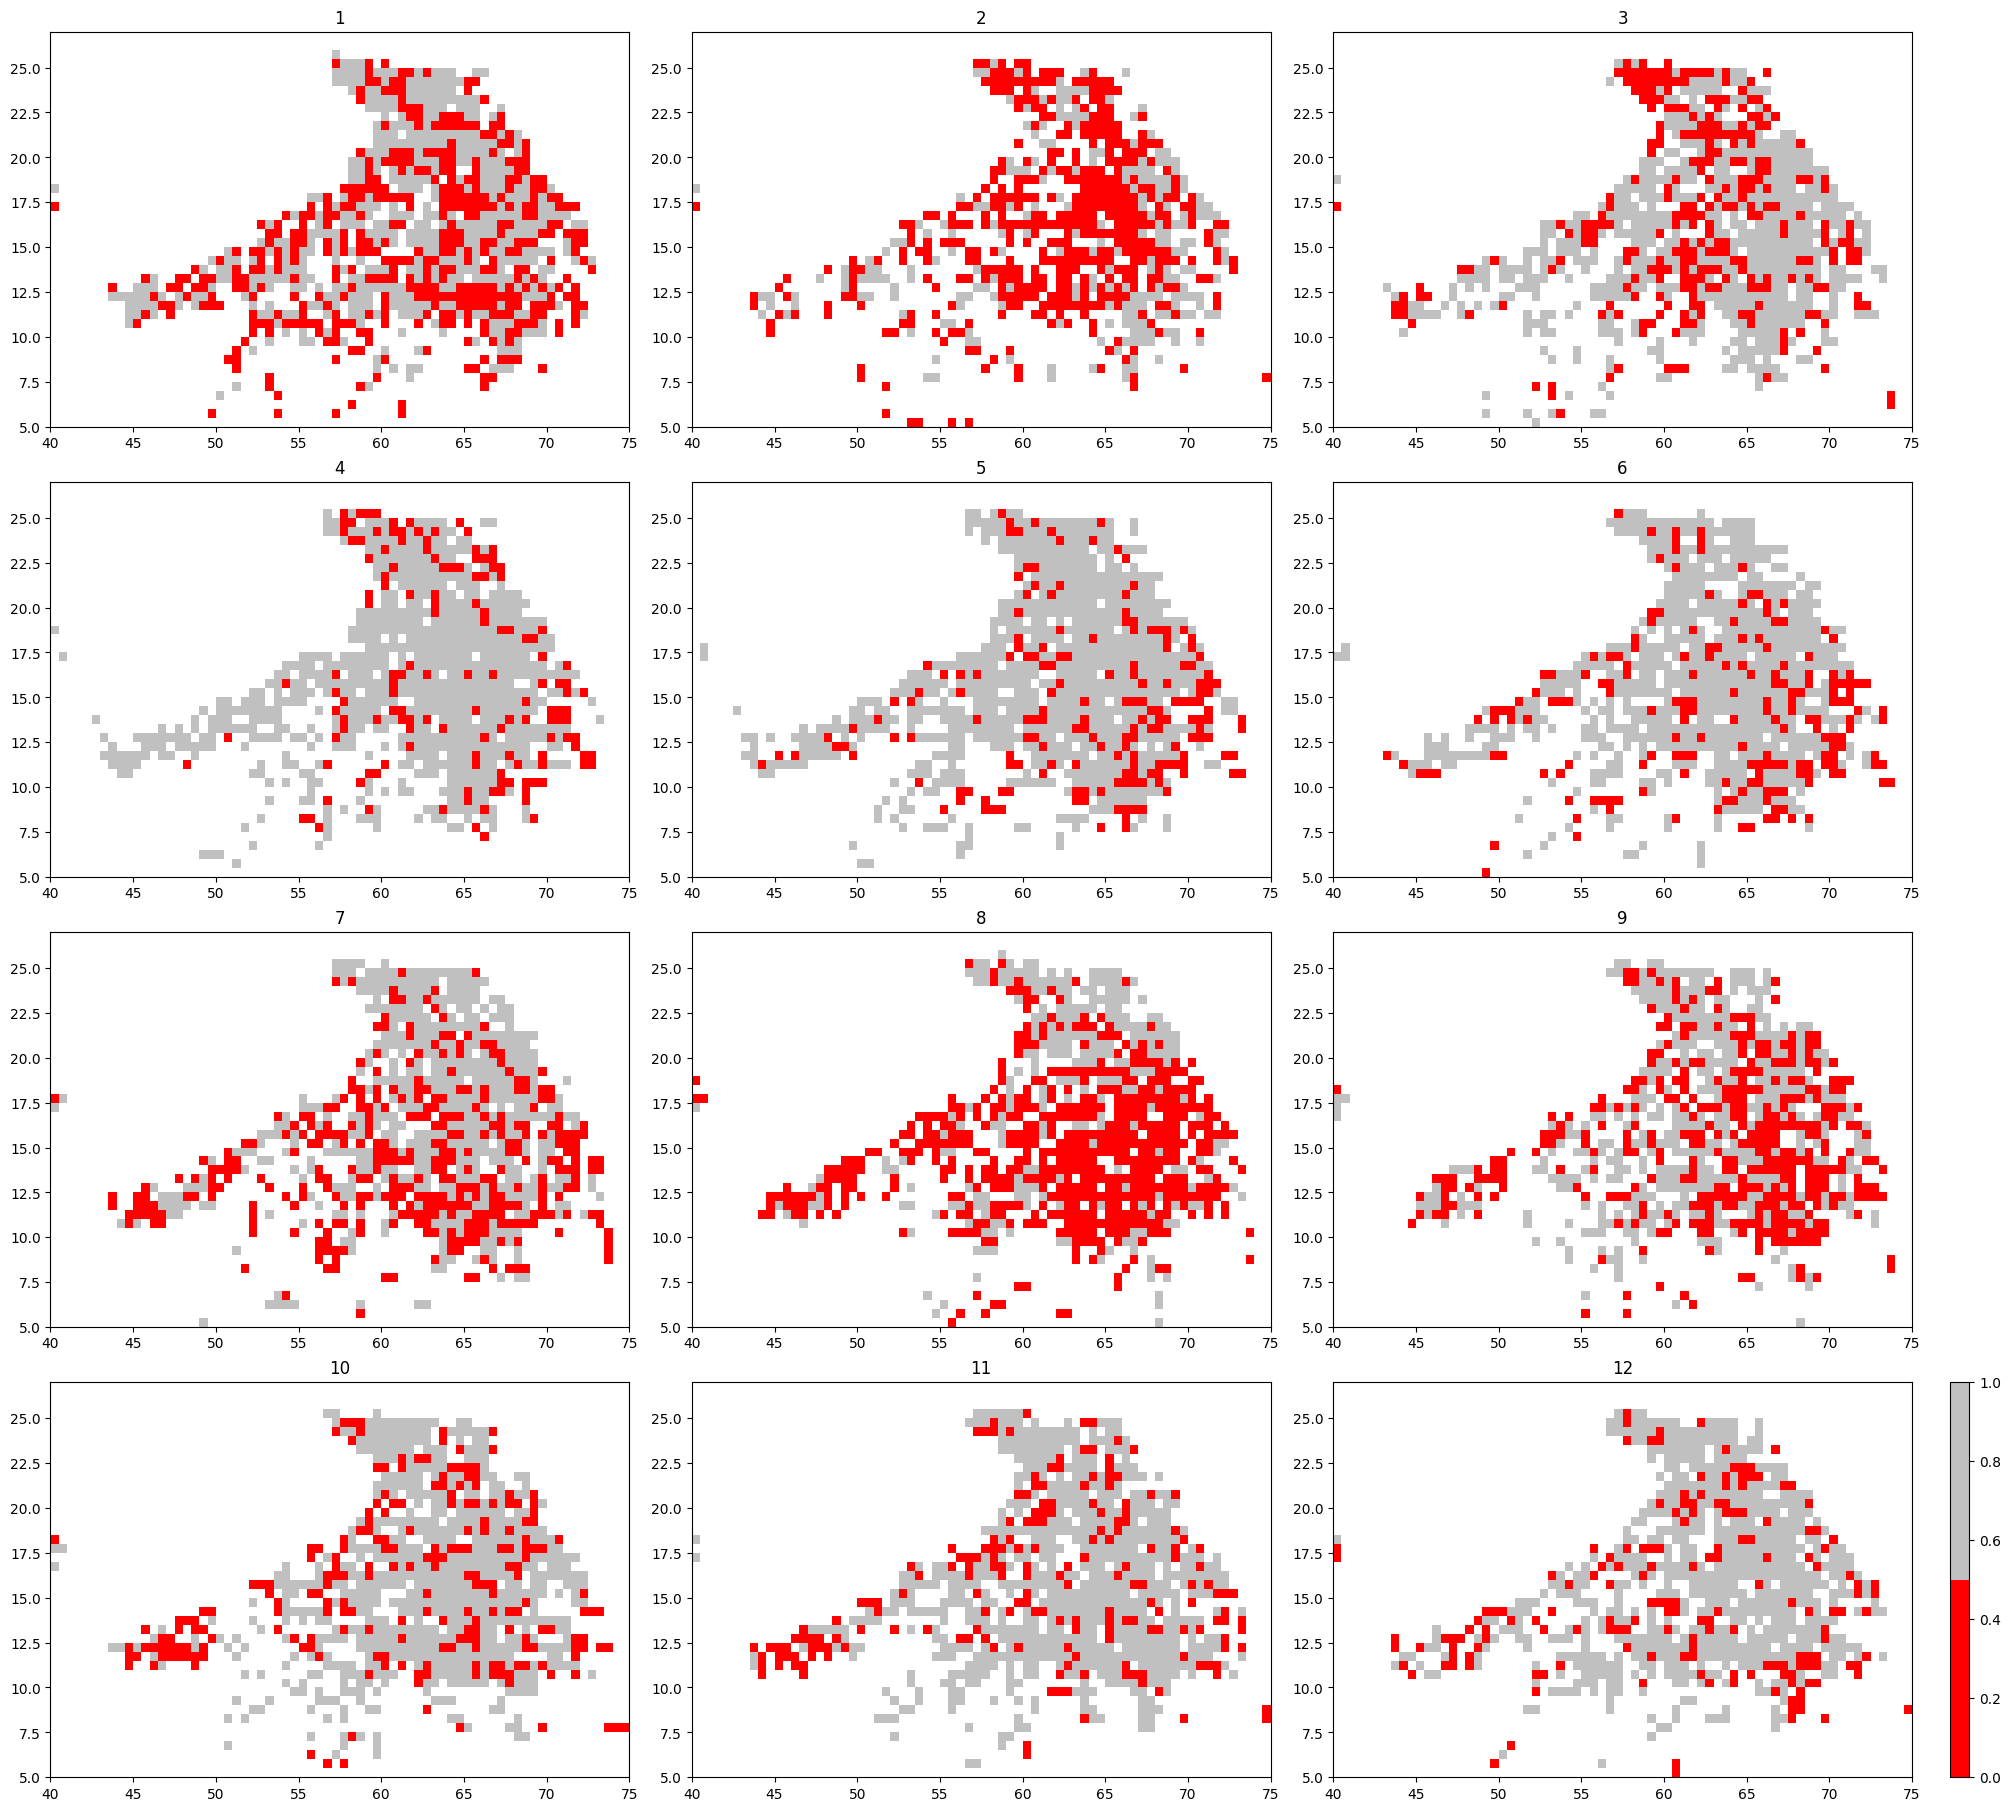

In [170]:
fig, ax=plt.subplots(4,3, figsize=(20,18), constrained_layout=True)
ax=ax.flatten()

for i in range(12):
    axi=ax[i]
    axi.set_title(str(i+1))
    cmap = cl.ListedColormap(['red', 'silver'])
    cb=axi.pcolormesh(lon, lat, regirded_df.isel(month=i).presence_mwl.T, cmap=cmap)
    axi.set_ylim(5,27)
    axi.set_xlim(40,75)

plt.colorbar(cb)

    # cmap = cl.ListedColormap(['white', [ 1. , 1. , 1. , 0.0]])
    # axi.pcolormesh(lon, lat,(regirded_df.isel(month=i).bot_mwl.T-regirded_df.isel(month=i).top_mwl.T)<10, cmap=cmap)
    # plt.show()

In [251]:
# df_nn.groupby_bins('latitude', bins=np.arange(5,30+5,5))

(15340.0, 16071.0)

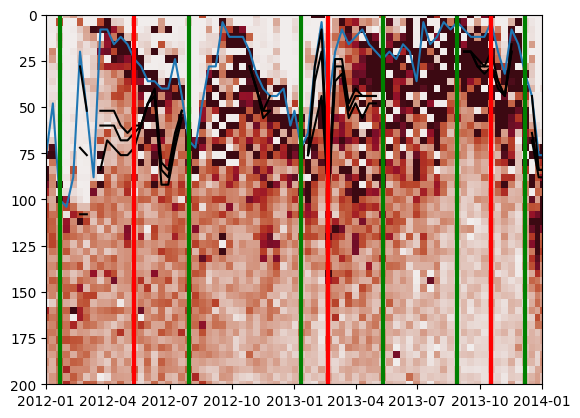

In [178]:
NNN=-28
plt.pcolormesh(df_arg.time,df_arg.pressure,  df_arg.sel(platform_num=platforms_numbers[NNN]).N2, cmap=cmo.amp, vmin=0, vmax=0.0003)
plt.ylim(200,0)
plt.plot(df_arg.time, df_arg.sel(platform_num=platforms_numbers[NNN]).mixed_layer_depth)
plt.plot(df_arg.time, df_arg.sel(platform_num=platforms_numbers[NNN]).top_mwl, c='k')
plt.plot(df_arg.time, df_arg.sel(platform_num=platforms_numbers[NNN]).bot_mwl, c='k')
plt.plot(df_arg.time, df_arg.sel(platform_num=platforms_numbers[NNN]).min_n2, c='k')


dates_st_end=formation_eros_date_paried(df_arg, NNN)
for i in range(len(dates_st_end[0][0])):
    plt.axvline(dates_st_end[0][:, i][0], c='green', lw=3)
    plt.axvline(dates_st_end[0][:, i][1], c='r', lw=3)

plt.xlim(pd.to_datetime('2012'), pd.to_datetime('2014'))
    

In [172]:
_f_=np.array([pd.to_datetime(0).to_numpy().astype('timedelta64[D]')])
for i in range(len(df_n)):
    # print(i)
    _f_=np.concatenate([_f_, np.array(formation_eros_date_paried(df_n, i)[1])])
    
_f_=_f_.astype(float)
_f_[_f_==-9223372036854775808]=np.nan
_f_[_f_==0]=np.nan

_f_2=np.array([pd.to_datetime(0).to_numpy().astype('timedelta64[D]')])
for i in range(len(df_s)):
    # print(i)
    _f_2=np.concatenate([_f_2, np.array(formation_eros_date_paried(df_s, i)[1])])
    
_f_2=_f_2.astype(float)
_f_2[_f_2==-9223372036854775808]=np.nan
_f_2[_f_2==0]=np.nan

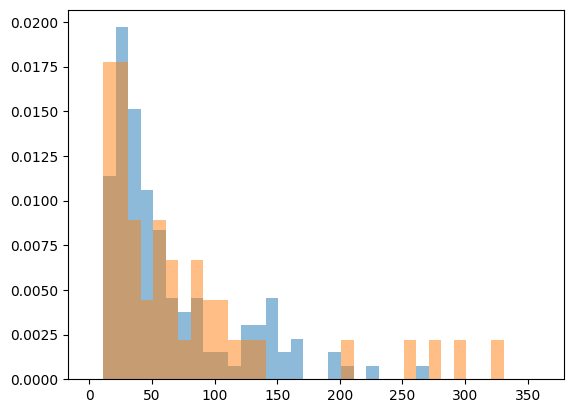

In [178]:
_=plt.hist(_f_2, np.arange(1,365, 10), density=True, alpha=0.5)
_=plt.hist(_f_, np.arange(1,365, 10), density=True, alpha=0.5)

  0%|          | 0/265 [00:00<?, ?it/s]

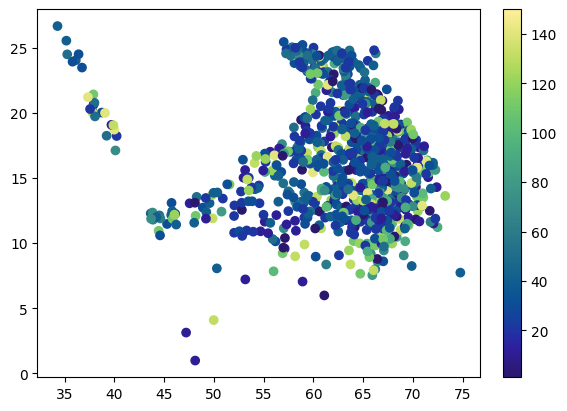

In [27]:
plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(121)
for ii in tqdm(df_arg.platform_num.values):
    clss=pd.to_datetime(get_time_formation(ii)).dayofyear.values.astype(float)
    clss[clss>150]=np.nan
    plt.scatter(get_latitude_formation(ii)[0], get_latitude_formation(ii)[1], c=clss, vmin=1, vmax=150, cmap=cmo.haline)

cbar=plt.colorbar()

In [ ]:
plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(121)
for ii in tqdm(df_arg.platform_num.values):
    clss=pd.to_datetime(get_time_formation(ii)).dayofyear.values.astype(float)
    clss[clss>150]=np.nan
    plt.scatter(get_latitude_formation(ii)[0], get_latitude_formation(ii)[1], c=clss, vmin=1, vmax=100, cmap=cmo.haline)

cbar=plt.colorbar()

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

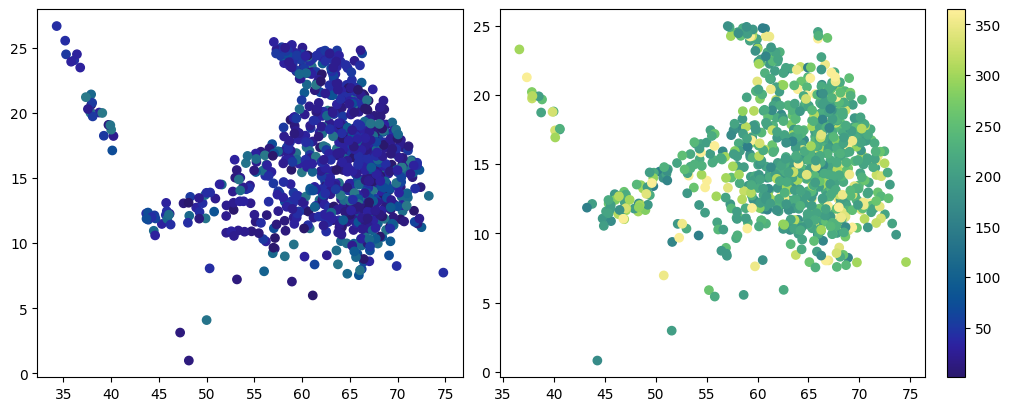

In [23]:
plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(121)
for ii in tqdm(df_arg.platform_num.values):
    clss=pd.to_datetime(get_time_formation(ii)).dayofyear.values.astype(float)
    clss[clss>150]=np.nan
    plt.scatter(get_latitude_formation(ii)[0], get_latitude_formation(ii)[1], c=clss, vmin=1, vmax=365, cmap=cmo.haline)

plt.subplot(122)
for ii in tqdm(df_arg.platform_num.values):
    clss=pd.to_datetime(get_time_formation(ii)).dayofyear.values.astype(float)
    clss[clss<150]=np.nan
    plt.scatter(get_latitude_formation(ii)[0], get_latitude_formation(ii)[1], c=clss, vmin=1, vmax=365, cmap=cmo.haline)

cbar=plt.colorbar()

In [ ]:
# for i in range(len(s_doy.platform_num)):
#     plt.plot(s_doy.dayofyear, s_doy.core_N2.isel(platform_num=i), lw=1, c='red')
    
for plat_i in n_doy.platform_num.values:
    for ii in get_time_formation(plat_i):
        plt.axvline(pd.to_datetime(ii).dayofyear)
    plt.scatter(pd.to_datetime(df_arg.sel(platform_num=plat_i).time).dayofyear, df_arg.sel(platform_num=plat_i).mixed_layer_depth, s=1, c='r')
    
# plt.ylim(0.000001,0.001)
# plt.yscale('log')

In [ ]:
# for i in range(len(s_doy.platform_num)):
#     plt.plot(s_doy.dayofyear, s_doy.core_N2.isel(platform_num=i), lw=1, c='red')
    
for plat_i in s_doy.platform_num.values:
    plt.scatter(pd.to_datetime(df_arg.sel(platform_num=plat_i).time).dayofyear, df_arg.sel(platform_num=plat_i).mixed_layer_depth, s=1, c='r')
    for ii in get_time_formation(plat_i):
        plt.axvline(pd.to_datetime(ii).dayofyear)
        
# plt.ylim(0.000001,0.001)
# plt.yscale('log')

In [ ]:
# for i in range(len(s_doy.platform_num)):
#     plt.plot(s_doy.dayofyear, s_doy.core_N2.isel(platform_num=i), lw=1, c='red')
    
# for i in range(2):
i=1
plt.scatter(pd.to_datetime(df_arg.time).dayofyear, df_arg.mixed_layer_depth.isel(platform_num=i), c='silver')
plat_i=s_doy.platform_num[i]
for ii in get_time_formation(plat_i):
    plt.axvline(pd.to_datetime(ii).dayofyear, c='r')
    
# plt.ylim(0.000001,0.001)
# plt.yscale('log')

In [ ]:
plt.plot(theta, radii2, c="#018dae", lw=3) 


In [14]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

Text(0, 0.5, '($\\mathbf{\\mu mol}$ $\\mathbf{kg^{-1}}$)')

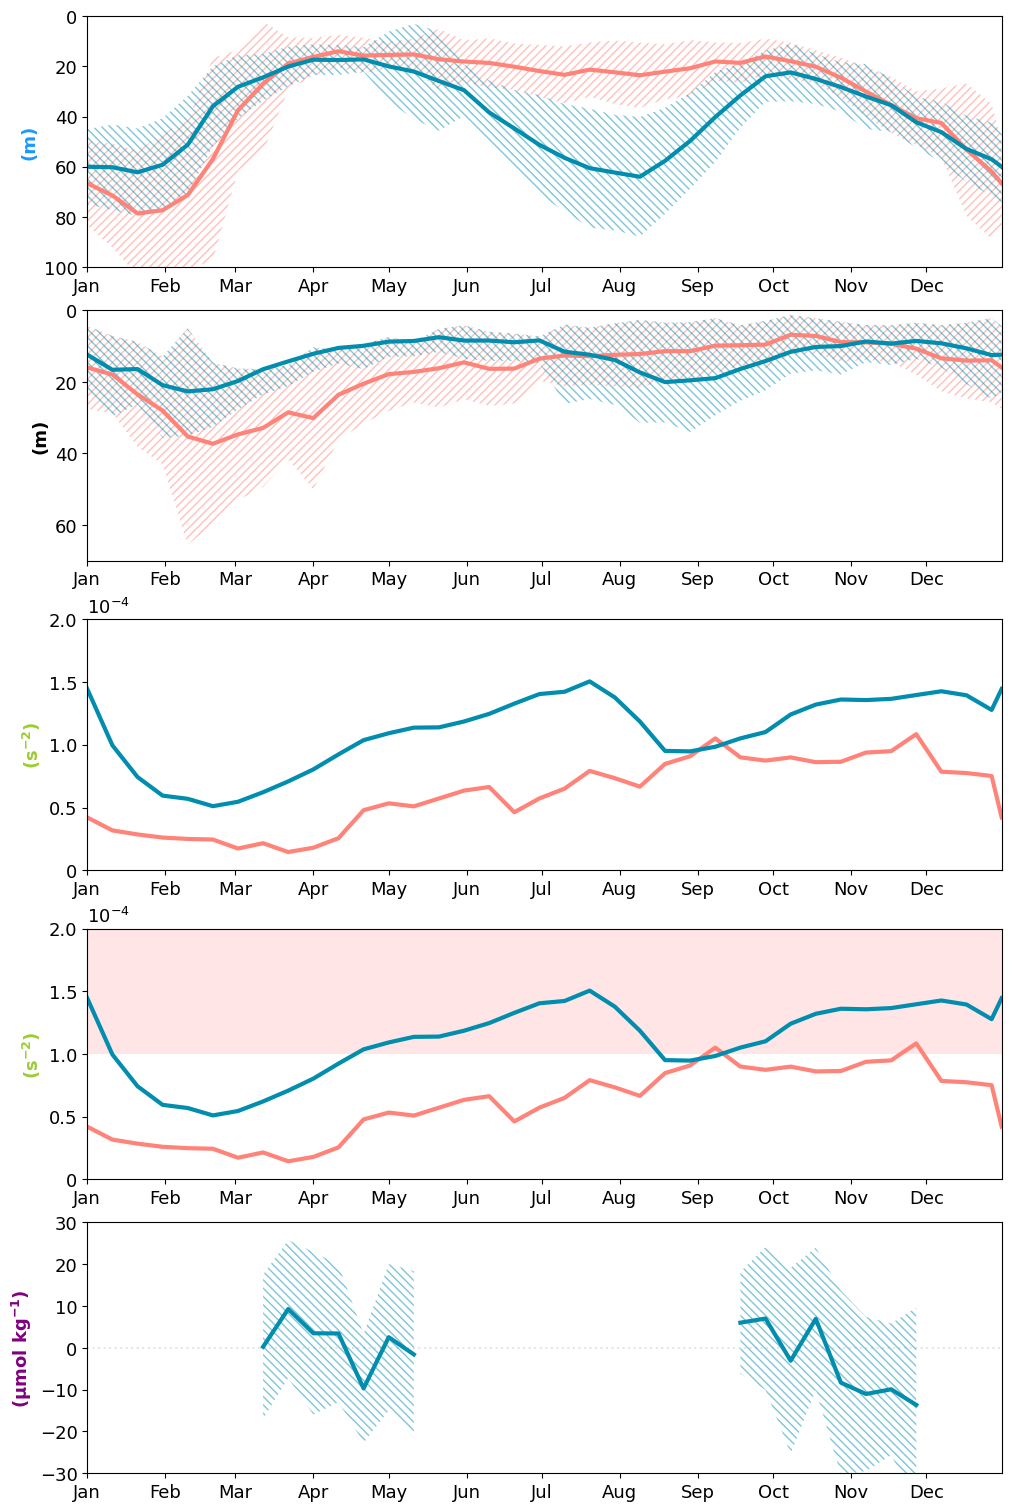

In [15]:
plt.figure(figsize=(10,15), constrained_layout=True)# Polar Plot theta (angle) and radii (length) settings 

plt.subplot(511)
theta = np.concatenate([n_doy.dayofyear.values, [365]])

theta = pd.to_datetime(theta, format='%j')
radii = np.concatenate([n_doy.mean('platform_num').mixed_layer_depth.values, [n_doy.mean('platform_num').mixed_layer_depth.values[0]]])
radii2 = np.concatenate([s_doy.mean('platform_num').mixed_layer_depth.values, [s_doy.mean('platform_num').mixed_layer_depth.values[0]]])

stdd = np.concatenate([n_doy.std('platform_num').mixed_layer_depth.values, [n_doy.std('platform_num').mixed_layer_depth.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').mixed_layer_depth.values, [s_doy.std('platform_num').mixed_layer_depth.values[0]]])

# Polar Plot 
plt.plot(theta, radii, c="#ff8379", lw=3) 
less_limit=(radii-stdd)
less_limit[less_limit<2]=2
plt.fill_between(theta, radii+stdd,less_limit, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.plot(theta, radii2, c="#018dae", lw=3) 
less_limit=(radii2-stdd2)
less_limit[less_limit<2]=2
plt.fill_between(theta, radii2+stdd2,less_limit, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
plt.ylim(100, 0) 
plt.xlim(theta[0], theta[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator( interval=1))
# plt.gca().set_rlabel_position(100)
# plt.gca().xaxis.grid(linewidth=0.5, ls=':')
# ax.yaxis.grid() # horizontal lines

plt.ylabel('(m)', c='#1998FF', fontweight='bold')
# plt.gca().set_rgrids([20,40,60,80], color='black', alpha=0.5)


plt.subplot(512)
theta = pd.to_datetime(theta, format='%j')
radii = np.concatenate([(n_doy.bot_mwl- n_doy.top_mwl).mean('platform_num').values, [(n_doy.bot_mwl- n_doy.top_mwl).mean('platform_num').values[0]]])
radii2 = np.concatenate([(s_doy.bot_mwl- s_doy.top_mwl).mean('platform_num').values, [(s_doy.bot_mwl- s_doy.top_mwl).mean('platform_num').values[0]]])

stdd = np.concatenate([(n_doy.bot_mwl- n_doy.top_mwl).std('platform_num').values, [(n_doy.bot_mwl- n_doy.top_mwl).std('platform_num').values[0]]])
stdd2 = np.concatenate([(s_doy.bot_mwl- s_doy.top_mwl).std('platform_num').values, [(s_doy.bot_mwl- s_doy.top_mwl).std('platform_num').values[0]]])
stdd[15]=(stdd[14]+stdd[17])/2
stdd[16]=(stdd[14]+stdd[17])/2

# Polar Plot 
plt.plot(theta, radii, c="#ff8379", lw=3) 

plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.plot(theta, radii2, c="#018dae", lw=3) 
less_limit=(radii2-stdd2)
less_limit[less_limit<10]=10
plt.fill_between(theta, radii2+stdd2,radii-stdd, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
plt.ylim(70, 0) 
plt.xlim(theta[0], theta[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator( interval=1))
# plt.gca().set_rlabel_position(100)
# plt.gca().xaxis.grid(linewidth=0.5, ls=':')
# ax.yaxis.grid() # horizontal lines

plt.ylabel('(m)', c='k', fontweight='bold')
# plt.gca().set_rgrids([20,40,60,80], color='black', alpha=0.5)

plt.subplot(514)
theta = pd.to_datetime(theta, format='%j')
radii = np.concatenate([n_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [n_doy.mean('platform_num').core_N2.values[0]]])
radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii[:1]=n_doy.mean('platform_num').core_N2.values[:1]
radii2[:1]=s_doy.mean('platform_num').core_N2.values[:1]
radii[-2:-1]=n_doy.mean('platform_num').core_N2.values[-1]
radii2[-2:-1]=s_doy.mean('platform_num').core_N2.values[-1]


stdd = np.concatenate([n_doy.std('platform_num').core_N2.values, [n_doy.std('platform_num').core_N2.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').core_N2.values, [s_doy.std('platform_num').core_N2.values[0]]])

# Polar Plot 
plt.plot(theta, radii, c="#ff8379", lw=3) 

# plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.plot(theta, radii2, c="#018dae", lw=3) 
# plt.fill_between(theta, radii2+stdd2,radii-stdd, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
plt.fill_between(theta,np.zeros(len(radii))+0.0001, np.zeros(len(radii))+0.001, color="red", alpha=0.1, linewidth=0.0) 

plt.ylim(0, 0.0002) 
# plt.yscale('log')
plt.xlim(theta[0], theta[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator( interval=1))
# plt.gca().set_rlabel_position(100)
# plt.gca().xaxis.grid(linewidth=0.5, ls=':')
# ax.yaxis.grid() # horizontal lines
plt.text(theta[0], 0.000205, s='$10^{-4}$', color='black')

plt.ylabel('($\mathbf{s^{-2}}$)', c='yellowgreen', fontweight='bold')
plt.gca().set_yticks([0,0.00005,0.0001, 0.00015,0.0002])
plt.gca().set_yticklabels(['0', '0.5', '1.0', '1.5', '2.0'])


plt.subplot(513)
theta = pd.to_datetime(theta, format='%j')
radii = np.concatenate([n_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [n_doy.mean('platform_num').core_N2.values[0]]])
radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii[:1]=n_doy.mean('platform_num').core_N2.values[:1]
radii2[:1]=s_doy.mean('platform_num').core_N2.values[:1]
radii[-2:-1]=n_doy.mean('platform_num').core_N2.values[-1]
radii2[-2:-1]=s_doy.mean('platform_num').core_N2.values[-1]


stdd = np.concatenate([n_doy.std('platform_num').core_N2.values, [n_doy.std('platform_num').core_N2.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').core_N2.values, [s_doy.std('platform_num').core_N2.values[0]]])

# Polar Plot 
plt.plot(theta, radii, c="#ff8379", lw=3) 

# plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.plot(theta, radii2, c="#018dae", lw=3) 
# plt.fill_between(theta, radii2+stdd2,radii-stdd, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
# plt.fill_between(theta,np.zeros(len(radii))+0.0001, np.zeros(len(radii))+0.001, color="red", alpha=0.1, linewidth=0.0) 

plt.ylim(0, 0.0002) 
# plt.yscale('log')
plt.xlim(theta[0], theta[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator( interval=1))
# plt.gca().set_rlabel_position(100)
# plt.gca().xaxis.grid(linewidth=0.5, ls=':')
# ax.yaxis.grid() # horizontal lines
plt.text(theta[0], 0.000205, s='$10^{-4}$', color='black')

plt.ylabel('($\mathbf{s^{-2}}$)', c='yellowgreen', fontweight='bold')
plt.gca().set_yticks([0,0.00005,0.0001, 0.00015,0.0002])
plt.gca().set_yticklabels(['0', '0.5', '1.0', '1.5', '2.0'])



msk_north=(df_arg_bg.latitude.mean('pressure').mean('time')>20) & (df_arg_bg.longitude.mean('pressure').mean('time')>50)
msk_south=(df_arg_bg.latitude.mean('pressure').mean('time')<20) & (df_arg_bg.longitude.mean('pressure').mean('time')>50)

lol_n=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_north]).groupby('time.year')
lol_s=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_south]).groupby('time.year')
yrs=np.arange(2021, 2024)

n_doy=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_north]).groupby('time.dayofyear').mean()
s_doy=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_south]).groupby('time.dayofyear').mean()



msk_=(n_doy.dayofyear>60) & (n_doy.dayofyear<150)
n_doy['core_oxygen_concentration_anomaly']=n_doy['core_oxygen_concentration']-n_doy['core_oxygen_concentration'][msk_].mean('dayofyear')
n_doy['core_aou_anomaly']=n_doy['core_aou']-n_doy['core_aou'][msk_].mean('dayofyear')

# msk_2=(n_doy.dayofyear>250) & (n_doy.dayofyear<325)      
# n_doy['core_potential_density_anomaly_2']=n_doy['core_potential_density']-n_doy['core_potential_density'][msk_2].mean('dayofyear')


msk_=(s_doy.dayofyear>60) & (s_doy.dayofyear<150)
s_doy['core_oxygen_concentration_anomaly']=s_doy['core_oxygen_concentration']-s_doy['core_oxygen_concentration'][msk_].mean('dayofyear')
s_doy['core_aou_anomaly']=s_doy['core_aou']-s_doy['core_aou'][msk_].mean('dayofyear')

msk_2=(s_doy.dayofyear>230) & (s_doy.dayofyear<330)      
s_doy['core_oxygen_concentration_anomaly_2']=s_doy['core_oxygen_concentration']-s_doy['core_oxygen_concentration'][msk_2].mean('dayofyear')
s_doy['core_aou_anomaly_2']=s_doy['core_aou']-s_doy['core_aou'][msk_2].mean('dayofyear')

plt.subplot(515)
plt.axhline(0,c='k', alpha=0.1, ls=':', zorder=-10)

theta = pd.to_datetime(theta, format='%j')
radii = np.concatenate([s_doy.mean('platform_num').core_oxygen_concentration_anomaly.values, [s_doy.mean('platform_num').core_oxygen_concentration_anomaly.values[0]]])
# radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii[:7]=np.nan
radii[14:]=np.nan

radii2 = np.concatenate([s_doy.mean('platform_num').core_oxygen_concentration_anomaly_2.values, [s_doy.mean('platform_num').core_oxygen_concentration_anomaly_2.values[0]]])
# radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii2[:26]=np.nan
radii2[34:]=np.nan

stdd = np.concatenate([s_doy.std('platform_num').core_oxygen_concentration_anomaly.values, [s_doy.std('platform_num').core_aou_anomaly.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').core_oxygen_concentration_anomaly_2.values, [s_doy.std('platform_num').core_aou_anomaly_2.values[0]]])
stdd[:7]=np.nan
stdd[14:]=np.nan

stdd2[:26]=np.nan
stdd2[35:]=np.nan
# Polar Plot 
plt.plot(theta, radii, c="#018dae", lw=3) 

plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


plt.plot(theta, radii2, c="#018dae", lw=3) 
plt.fill_between(theta, radii2+stdd2,radii2-stdd2, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
# plt.fill_between(theta,np.zeros(len(radii))+0.0001, np.zeros(len(radii))+0.001, color="red", alpha=0.1, linewidth=0.0) 

plt.ylim(-30, 30) 
# plt.yscale('log')
plt.xlim(theta[0], theta[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator( interval=1))
# plt.gca().set_rlabel_position(100)
# plt.gca().xaxis.grid(linewidth=0.5, ls=':')
# ax.yaxis.grid() # horizontal lines
# plt.text(theta[0], 0.000205, s='$10^{-4}$', color='black')
plt.ylabel('($\mathbf{\mu mol}$ $\mathbf{kg^{-1}}$)', c='purple', fontweight='bold')

(<a list of 5 Line2D gridline objects>,
 [Text(0, 20, '20'),
  Text(0, 40, '40'),
  Text(0, 60, '60'),
  Text(0, 80, '80'),
  Text(0, 100, '100')])

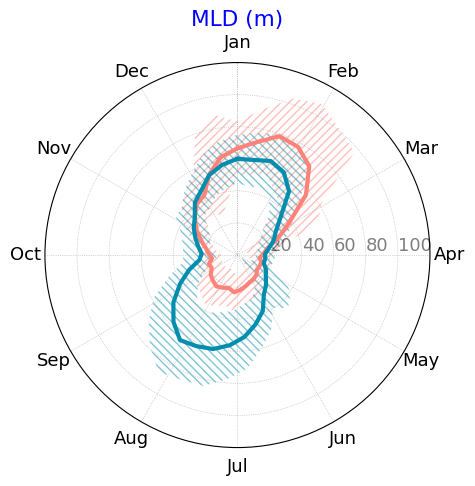

In [28]:
# Polar Plot theta (angle) and radii (length) settings 
theta = np.linspace(0,2*np.pi, len(n_doy.dayofyear.values)+1)
radii = np.concatenate([n_doy.mean('platform_num').mixed_layer_depth.values, [n_doy.mean('platform_num').mixed_layer_depth.values[0]]])
radii2 = np.concatenate([s_doy.mean('platform_num').mixed_layer_depth.values, [s_doy.mean('platform_num').mixed_layer_depth.values[0]]])


stdd = np.concatenate([n_doy.std('platform_num').mixed_layer_depth.values, [n_doy.std('platform_num').mixed_layer_depth.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').mixed_layer_depth.values, [s_doy.std('platform_num').mixed_layer_depth.values[0]]])

# Polar Plot 
plt.figure(figsize=(7, 5)) 
plt.polar(theta, radii, c="#ff8379", lw=3) 
less_limit=(radii-stdd)
less_limit[less_limit<2]=2
plt.fill_between(theta, radii+stdd,less_limit, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.polar(theta, radii2, c="#018dae", lw=3) 
less_limit=(radii2-stdd2)
less_limit[less_limit<2]=2
plt.fill_between(theta, radii2+stdd2,less_limit, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
plt.gca().set_theta_zero_location("N")
plt.gca().set_theta_direction(-1)  # theta increasing clockwise
plt.ylim(0, 120) 

theta_m = np.linspace(0, 2 * np.pi, 13) 
plt.xticks(theta_m, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                   'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']) 
plt.gca().set_rlabel_position(90)
plt.gca().grid(linewidth=0.5, ls=':')
plt.title('MLD (m)', c='blue')
plt.gca().set_rgrids([20,40,60,80, 100], color='black', alpha=0.5)



(<a list of 3 Line2D gridline objects>,
 [Text(0, 20, '20'), Text(0, 40, '40'), Text(0, 60, '60')])

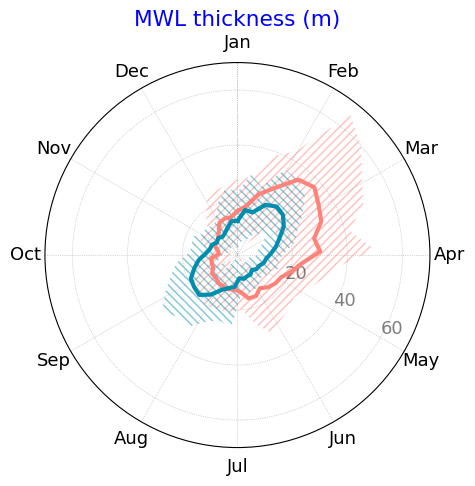

In [29]:
# Polar Plot theta (angle) and radii (length) settings 
theta = np.linspace(0,2*np.pi, len(n_doy.dayofyear.values)+1)
# radii = np.concatenate([(n_doy.mean('platform_num').bot_mwl- n_doy.mean('platform_num').top_mwl).values, [(n_doy.mean('platform_num').bot_mwl- n_doy.mean('platform_num').top_mwl).values[0]]])
# radii2 = np.concatenate([(s_doy.mean('platform_num').bot_mwl- s_doy.mean('platform_num').top_mwl).values, [(s_doy.mean('platform_num').bot_mwl- s_doy.mean('platform_num').top_mwl).values[0]]])

radii = np.concatenate([(n_doy.bot_mwl- n_doy.top_mwl).mean('platform_num').values, [(n_doy.bot_mwl- n_doy.top_mwl).mean('platform_num').values[0]]])
radii2 = np.concatenate([(s_doy.bot_mwl- s_doy.top_mwl).mean('platform_num').values, [(s_doy.bot_mwl- s_doy.top_mwl).mean('platform_num').values[0]]])


stdd = np.concatenate([(n_doy.bot_mwl- n_doy.top_mwl).std('platform_num').values, [(n_doy.bot_mwl- n_doy.top_mwl).std('platform_num').values[0]]])
stdd2 = np.concatenate([(s_doy.bot_mwl- s_doy.top_mwl).std('platform_num').values, [(s_doy.bot_mwl- s_doy.top_mwl).std('platform_num').values[0]]])
# stdd[15]=(stdd[14]+stdd[17])/2
# stdd[16]=(stdd[14]+stdd[17])/2

plt.figure(figsize=(7, 5)) 
plt.polar(theta, radii, c="#ff8379", lw=3) 
# less_limit=(radii-stdd)
# less_limit[less_limit<10]=10
plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.polar(theta, radii2, c="#018dae", lw=3) 
# less_limit=(radii2-stdd2)
# less_limit[less_limit<10]=10
plt.fill_between(theta, radii2+stdd2,radii2-stdd2, color="none",hatch="\\\\\\\\",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
plt.gca().set_theta_zero_location("N")
plt.gca().set_theta_direction(-1)  # theta increasing clockwise
plt.ylim(0, 70) 

theta_m = np.linspace(0, 2 * np.pi, 13) 
plt.xticks(theta_m, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                   'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']) 
plt.gca().set_rlabel_position(120)
plt.gca().grid(linewidth=0.5, ls=':')
plt.title('MWL thickness (m)', c='blue')
plt.gca().set_rgrids([20,40,60], color='black', alpha=0.5)



Text(0.7853981633974483, 0.0002, '$10^{-4}$')

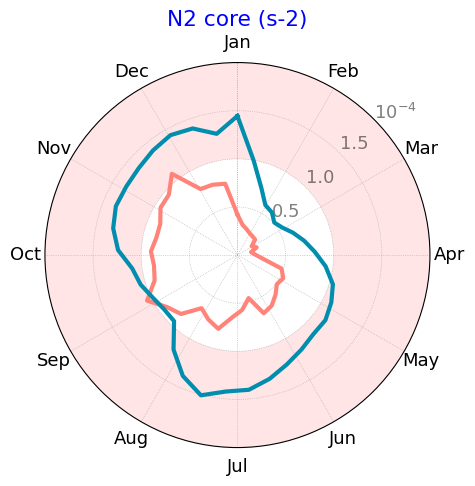

In [30]:
# Polar Plot theta (angle) and radii (length) settings 
theta = np.linspace(0,2*np.pi, len(n_doy.dayofyear.values)+1)
radii = np.concatenate([n_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [n_doy.mean('platform_num').core_N2.values[0]]])
radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii[:1]=n_doy.mean('platform_num').core_N2.values[:1]
radii2[:1]=s_doy.mean('platform_num').core_N2.values[:1]
radii[-2:-1]=n_doy.mean('platform_num').core_N2.values[-1]
radii2[-2:-1]=s_doy.mean('platform_num').core_N2.values[-1]


stdd = np.concatenate([n_doy.std('platform_num').core_N2.values, [n_doy.std('platform_num').core_N2.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').core_N2.values, [s_doy.std('platform_num').core_N2.values[0]]])

# Polar Plot 
plt.figure(figsize=(7, 5)) 
plt.polar(theta, radii, c="#ff8379", lw=3) 
# less_limit=(radii-stdd)
# less_limit[less_limit<10]=10
# plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="////",edgecolor="#ff8379", alpha=0.5, linewidth=0.0) 


plt.polar(theta, radii2, c="#018dae", lw=3) 
# less_limit=(radii2-stdd2)
# less_limit[less_limit<10]=10
plt.fill_between(theta, np.ones(len(radii2))*0.0001,np.ones(len(radii2))*0.00025, color="red", alpha=0.1, linewidth=0.0, zorder=-100) 


### 
plt.gca().set_theta_zero_location("N")
plt.gca().set_theta_direction(-1)  # theta increasing clockwise
plt.ylim(0, 0.0002) 

theta_m = np.linspace(0, 2 * np.pi, 13) 
plt.xticks(theta_m, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                   'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']) 
plt.gca().set_rlabel_position(45)
plt.gca().grid(linewidth=0.5, ls=':')
plt.title('N2 core (s-2)', c='blue')
plt.gca().set_rgrids([0.00005, 0.0001, 0.00015], labels=['0.5', '1.0', '1.5'], color='black', alpha=0.5)

plt.text((np.pi/2)/2, 0.0002, s='$10^{-4}$', color='black', alpha=0.5)

In [31]:
msk_north=(df_arg_bg.latitude.mean('pressure').mean('time')>20) & (df_arg_bg.longitude.mean('pressure').mean('time')>50)
msk_south=(df_arg_bg.latitude.mean('pressure').mean('time')<20) & (df_arg_bg.longitude.mean('pressure').mean('time')>50)

lol_n=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_north]).groupby('time.year')
lol_s=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_south]).groupby('time.year')
yrs=np.arange(2021, 2024)

n_doy=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_north]).groupby('time.dayofyear').mean()
s_doy=df_arg_bg.sel(platform_num=df_arg_bg.platform_num[msk_south]).groupby('time.dayofyear').mean()



msk_=(n_doy.dayofyear>60) & (n_doy.dayofyear<150)
n_doy['core_oxygen_concentration_anomaly']=n_doy['core_oxygen_concentration']-n_doy['core_oxygen_concentration'][msk_].mean('dayofyear')
n_doy['core_aou_anomaly']=n_doy['core_aou']-n_doy['core_aou'][msk_].mean('dayofyear')

# msk_2=(n_doy.dayofyear>250) & (n_doy.dayofyear<325)      
# n_doy['core_potential_density_anomaly_2']=n_doy['core_potential_density']-n_doy['core_potential_density'][msk_2].mean('dayofyear')


msk_=(s_doy.dayofyear>60) & (s_doy.dayofyear<150)
s_doy['core_oxygen_concentration_anomaly']=s_doy['core_oxygen_concentration']-s_doy['core_oxygen_concentration'][msk_].mean('dayofyear')
s_doy['core_aou_anomaly']=s_doy['core_aou']-s_doy['core_aou'][msk_].mean('dayofyear')

msk_2=(s_doy.dayofyear>230) & (s_doy.dayofyear<330)      
s_doy['core_oxygen_concentration_anomaly_2']=s_doy['core_oxygen_concentration']-s_doy['core_oxygen_concentration'][msk_2].mean('dayofyear')
s_doy['core_aou_anomaly_2']=s_doy['core_aou']-s_doy['core_aou'][msk_2].mean('dayofyear')

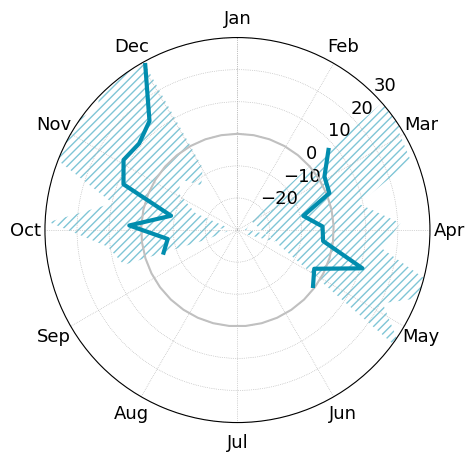

In [32]:
# Polar Plot theta (angle) and radii (length) settings 
theta = np.linspace(0,2*np.pi, len(n_doy.dayofyear.values)+1)
radii = np.concatenate([s_doy.mean('platform_num').core_aou_anomaly.values, [s_doy.mean('platform_num').core_aou_anomaly.values[0]]])
# radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii[:5]=np.nan
radii[14:]=np.nan

radii2 = np.concatenate([s_doy.mean('platform_num').core_aou_anomaly_2.values, [s_doy.mean('platform_num').core_aou_anomaly_2.values[0]]])
# radii2 = np.concatenate([s_doy.mean('platform_num').core_N2.rolling(dayofyear=3, center=True).mean().values, [s_doy.mean('platform_num').core_N2.values[0]]])
radii2[:26]=np.nan
radii2[35:]=np.nan


stdd = np.concatenate([s_doy.std('platform_num').core_aou_anomaly_2.values, [s_doy.std('platform_num').core_aou_anomaly_2.values[0]]])
stdd2 = np.concatenate([s_doy.std('platform_num').core_aou_anomaly_2.values, [s_doy.std('platform_num').core_aou_anomaly_2.values[0]]])
stdd[:5]=np.nan
stdd[14:]=np.nan

stdd2[:26]=np.nan
stdd2[35:]=np.nan
# Polar Plot 
plt.figure(figsize=(7, 5)) 

plt.polar(theta, np.zeros(len(theta)), c='silver')


plt.polar(theta, radii, c="#018dae", lw=3) 
# less_limit=(radii-stdd)
# less_limit[less_limit<10]=10
plt.fill_between(theta, radii+stdd,radii-stdd, color="none",hatch="////",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


plt.polar(theta, radii2, c="#018dae", lw=3) 
# less_limit=(radii2-stdd2)
# less_limit[less_limit<10]=10
plt.fill_between(theta, radii2+stdd2,radii2-stdd2, color="none",hatch="////",edgecolor="#018dae", alpha=0.5, linewidth=0.0) 


### 
plt.gca().set_theta_zero_location("N")
plt.gca().set_theta_direction(-1)  # theta increasing clockwise
plt.ylim(-30,30) 

theta_m = np.linspace(0, 2 * np.pi, 13) 
plt.xticks(theta_m, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                   'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']) 
plt.gca().set_rlabel_position(45)
plt.gca().grid(linewidth=0.5, ls=':')
plt.title('o2', c='blue')
# plt.gca().set_rgrids([-10, 0.0001, 0.00015, 0.0002], labels=['0.5', '1.0', '1.5', '2.0'], color='black', alpha=0.5)

# plt.text((np.pi/2)/2, 0.000255, s='$10^{-4}$', color='black', alpha=0.5)

In [ ]:
# # plt.subplot(514)

# # lol=df_arg.groupby('time.year')
# # plt.figure(figsize=(25,5))
# plt.figure(figsize=(15,3), constrained_layout=True)

# for ii in yrs:
#     lola=lol_s[ii]
#     for i in range(len(lola.platform_num)):
#         # if (np.count_nonzero(np.isfinite(lola.isel(platform_num=i).mwd))>1):
#         plt.scatter(lola.time.dt.dayofyear, lola.isel(platform_num=i).bot_mwl.rolling(time=3, center=True).mean()-lola.isel(platform_num=i).mwd.rolling(time=3, center=True).mean(), s=5, c='k', alpha=0.5)
#         # else:
# for ii in yrs:
#     lola=lol_n[ii]
#     for i in range(len(lola.platform_num)):
#         # if (np.count_nonzero(np.isfinite(lola.isel(platform_num=i).mwd))>1):
#         plt.scatter(lola.time.dt.dayofyear, lola.isel(platform_num=i).bot_mwl.rolling(time=3, center=True).mean()-lola.isel(platform_num=i).mwd.rolling(time=3, center=True).mean(), s=5, c='r', alpha=0.5)
#         # else:
#     # print('ups')
# plt.plot(n_doy.dayofyear, n_doy.mean('platform_num').bot_mwl- n_doy.mean('platform_num').mwd, c='r', lw=5, zorder=100, label='Lat > 20N')
# plt.ylabel('Thickness MWL (m)')

# plt.plot(s_doy.dayofyear, s_doy.mean('platform_num').bot_mwl-s_doy.mean('platform_num').mwd, c='k', lw=5, zorder=100, label='Lat < 20N')
# # plt.ylim(50,0)
# # plt.xlabel('day of year')
# plt.xlim(0,365)
# plt.xticks([])

In [ ]:
# plt.figure(figsize=(15,3), constrained_layout=True)

# # plt.subplot(411)
# # lol=df_arg.groupby('time.year')
# # plt.figure(figsize=(25,5))
# for ii in yrs:
#     lola=lol_s[ii]
#     for i in range(len(lola.platform_num)):
#         # if (np.count_nonzero(np.isfinite(lola.isel(platform_num=i).mwd))>1):
#         plt.scatter(lola.time.dt.dayofyear, lola.isel(platform_num=i).core_N2.rolling(time=3, center=True).mean(),  s=5, c='k', alpha=0.5)
#         # else:
# for ii in yrs:
#     lola=lol_n[ii]
#     for i in range(len(lola.platform_num)):
#         # if (np.count_nonzero(np.isfinite(lola.isel(platform_num=i).mwd))>1):
#         plt.scatter(lola.time.dt.dayofyear, lola.isel(platform_num=i).core_N2.rolling(time=3, center=True).mean(), s=5, c='r', alpha=0.5)
#         # else:
#     # print('ups')
# plt.plot(n_doy.dayofyear, n_doy.mean('platform_num').core_N2, c='r', lw=5, zorder=100, label='Lat > 20N')
# plt.ylabel('$N^2$ at core')

# plt.plot(s_doy.dayofyear, s_doy.mean('platform_num').core_N2, c='k', lw=5, zorder=100, label='Lat < 20N')
# plt.ylim(0,0.0002)
# # plt.xlabel('day of year')
# # plt.legend()

# plt.xticks([])

# plt.xlim(0,365)

In [ ]:
lola.core_potential_density.rolling(time=3, center=True).mean()

In [ ]:
plt.figure(figsize=(15,3), constrained_layout=True)

# plt.subplot(411)
lol=df_arg.groupby('time.year')
plt.figure(figsize=(25,5))
for ii in yrs:
    lola=lol_s[ii]
    for i in range(len(lola.platform_num)):
        # if (np.count_nonzero(np.isfinite(lola.isel(platform_num=i).mwd))>1):
        meann=lola.core_potential_density.isel(platform_num=i).mean('time')
        plt.scatter(lola.time.dt.dayofyear, lola.core_potential_density.rolling(time=3, center=True).mean().isel(platform_num=i)-meann, s=5, c='k', alpha=0.5)
        # plt.scatter(lola.time.dt.dayofyear, lola.core_potential_density_anomaly_2.isel(platform_num=i).rolling(time=3, center=True).mean(), s=5, c='k', alpha=0.5)
        
#         # else:
for ii in yrs:
    lola=lol_n[ii]
    for i in range(len(lola.platform_num)):
        meann=lola.core_potential_density.isel(platform_num=i).mean('time')
        plt.scatter(lola.time.dt.dayofyear, lola.core_potential_density.rolling(time=3, center=True).mean().isel(platform_num=i)-meann, s=5, c='r', alpha=0.5)
#         plt.scatter(lola.time.dt.dayofyear, lola.core_potential_density.isel(platform_num=i).rolling(time=3, center=True).mean()-meann, s=5, c='r', alpha=0.5)
#         # else:
    # print('ups')
plt.plot(n_doy.dayofyear[3:33], n_doy.core_potential_density_anomaly.mean('platform_num')[3:33], c='r', lw=5, zorder=100, label='Lat > 20N')
plt.ylabel('$\sigma_0$ at core')

plt.plot(s_doy.dayofyear[3:16],(s_doy.core_potential_density_anomaly).mean('platform_num')[3:16], c='k', lw=5, zorder=100, label='Lat < 20N')
plt.plot(s_doy.dayofyear[23:33],(s_doy.core_potential_density_anomaly_2).mean('platform_num')[23:33], c='k', lw=5, zorder=100, label='Lat < 20N')

plt.ylim(-0.5,0.5)
plt.axhline(0, alpha=0.5, c='silver')
# plt.xlabel('day of year')
# plt.legend()

plt.xticks([])

plt.xlim(0,365)

In [ ]:
# lol=df_arg.groupby('time.year')
# plt.figure(figsize=(25,5))
# for ii in yrs:
#     lola=lol[ii]
#     for i in range(265):
#         if (np.count_nonzero(np.isfinite(lola.isel(platform_num=i).mwd))>1):
#             if (lola.latitude.mean('pressure').mean('time')[i].values>21):
#                 colorss='r'
#             else:
#                 colorss='k'
#             plt.plot(lola.time.dt.dayofyear, lola.isel(platform_num=i).mwd.interpolate_na('time').rolling(time=5, center=True).mean(), c=colorss)
# plt.ylim(140,0)
# plt.ylabel('MWD-MLD')

## Process ALL argo in the Arabian Sea between 2000 and 2023

In [13]:
df_argo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/datasets/ARGO_30_80_-5_30_2001_2023_fetcher.nc')

def mask(ArgoSet):
    msk=((ArgoSet.PSAL_QC==1) & (ArgoSet.PRES_QC==1) & (ArgoSet.TEMP_QC==1)).astype(float)
    msk[msk==0]=np.nan
    ArgoSet['PSAL_QC']=msk

def argo_process(ArgoSet):
    mask(ArgoSet)
    ArgoSet['abs_salinity'] = ('time', gsw.SA_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values, ArgoSet['longitude'].values,ArgoSet['latitude'].values))
    ArgoSet['cons_temp'] = ('time',gsw.CT_from_t(ArgoSet['abs_salinity'].values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values,(ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))
    # ArgoSet['conductivity']=('time', gsw.C_from_SP((ArgoSet['PSAL']*ArgoSet['PSAL_QC']).values,(ArgoSet['TEMP']*ArgoSet['PSAL_QC']).values, (ArgoSet['pressure']*ArgoSet['PSAL_QC']).values))    
    ArgoSet['potential_density'] = ('time',gsw.sigma0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values))
    # ArgoSet['spice']=('time', gsw.spiciness0(ArgoSet['abs_salinity'].values,ArgoSet['cons_temp'].values) )    
    
    ArgoSet=ArgoSet.rename_vars({'PLATFORM_NUMBER':'platform_num' })    
    return ArgoSet

df_argo=argo_process(df_argo)

vars_to_drop=['CONFIG_MISSION_NUMBER',
 'DATA_MODE',
 'DIRECTION',
 'POSITION_QC',
 'PRES_QC',
 'PSAL',
 'PSAL_QC',
 'TEMP',
 'TEMP_QC',
 'TIME_QC',
 'N_POINTS',
 'conductivity',
 'spice']

df_argo=df_argo.drop_vars(vars_to_drop)
df_argo=df_argo.where(df_argo.potential_density>20).where(df_argo.potential_density<30).where(df_argo.abs_salinity>33).where(df_argo.cons_temp>2)

# grid per platform
ds_platform_num=df_argo.groupby('platform_num')

del df_argo
gc.collect()

PlatformNum=list(ds_platform_num.groups.keys())
platforms_good=[]
for i in tqdm(PlatformNum):
    dff=ds_platform_num[i]
    num_days=((dff.time.max()-dff.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
    lat, lon=np.nanmean(dff.latitude), np.nanmean(dff.longitude)
    if (num_days>(30*3)):# & (lat>10):
        platforms_good.append(i)
        
platforms_numbers=np.array(platforms_good)

len(platforms_numbers)

  0%|          | 0/678 [00:00<?, ?it/s]

579

In [18]:
# platforms_numbers

In [16]:
# def make_nc_dataset_argos_wwl():
#     m=0
#     float_init=0
#     float_1=ds_platform_num[platforms_numbers[m]]#206 268 220 230
#     float_2=gridded_df_af(float_1)
#     float_3=_get_bottom_top_mode_water(float_2)
#     df_arg_all= float_3.assign_coords({"platform_num":platforms_numbers[m]}).expand_dims("platform_num")
#     # df_arg_all.to_netcdf('bgq_argo_wwl_'+str(float_init)+'_'+str(m)+'floats.nc')    
#     # del float_1
#     for plt_ in tqdm(platforms_numbers[1:len(platforms_numbers)+1]):
#         # print(plt_)
#         m=m+1
#         # df_arg_all=xr.open_dataset('bgq_argo_wwl_'+str(float_init)+'_'+str(m-1)+'floats.nc')
#         float_1=ds_platform_num[plt_]#206 268 220 230
#         if (np.count_nonzero(np.isfinite(float_1.pressure))!=0):
#             float_2=gridded_df_af(float_1)
#             if (np.count_nonzero(np.isfinite(float_2.mixed_layer_depth))!=0):
#                 float_3=_get_bottom_top_mode_water(float_2)
#                 float_4= float_3.assign_coords({"platform_num":plt_}).expand_dims("platform_num")    
#                 df_arg_all=xr.merge([df_arg_all, float_4])
#                 # df_arg_all.to_netcdf('bgq_argo_wwl_'+str(float_init)+'_'+str(m)+'floats.nc')    
#                 # gc.collect()
#                 # os.remove('bgq_argo_wwl_'+str(float_init)+'_'+str(m-1)+'floats.nc')
#         else:
#             print(plt_,  ' didnt work!')

#     df_arg_all.to_netcdf('argo_wwl_'+str(float_init)+'_'+str(m)+'floats.nc')   

In [63]:
def make_nc_dataset_argos_wwl(float_init, float_final):
    # float init, yr 1st:
    for plt_ in platforms_numbers[float_init:float_init+1]:
        fr_plt=ds_platform_num[plt_].groupby('time.year')
        years_=list(fr_plt.groups.keys())    
        for yr_ in years_[:1]:
            fr_plt_yr=fr_plt[yr_]
            # print(np.nanmean(fr_plt[yr_].latitude))
            df_arg=gridded_df_af(fr_plt_yr, str(yr_))
            if np.count_nonzero(~np.isnan(df_arg.abs_salinity))!=0:
                df_arg=get_max_dense(df_arg, NN_af, 1) 
                df_arg_all= df_arg.assign_coords({"platform_num":plt_}).expand_dims("platform_num")

    # float init, yr 2nd -last:
    for plt_ in platforms_numbers[float_init:float_init+1]:
        fr_plt=ds_platform_num[plt_].groupby('time.year')
        years_=list(fr_plt.groups.keys())    
        for yr_ in years_[1:]:
            fr_plt_yr=fr_plt[yr_]
            num_days=((fr_plt_yr.time.max()-fr_plt_yr.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
            if (num_days >3*30):
                # print(np.nanmean(fr_plt[yr_].latitude))
                df_arg=gridded_df_af(fr_plt_yr, str(yr_))     
                if np.count_nonzero(~np.isnan(df_arg.abs_salinity))!=0:
                    df_arg=get_max_dense(df_arg, NN_af, 1) 
                    df_arg= df_arg.assign_coords({"platform_num":plt_}).expand_dims("platform_num")
                    df_arg_all=xr.merge([df_arg_all, df_arg])
   
    # save nc with float init, yr 2nd -last:
    df_arg_all.to_netcdf('argo_wwl_'+str(float_init)+'_'+str(float_init)+'floats.nc')    

    # # # all the rest!:
    for NN_s in tqdm(range(float_init+1, float_final,1)):
        df_arg_all=xr.open_dataset('argo_wwl_'+str(float_init)+'_'+str(NN_s-1)+'floats.nc')
        plt_=platforms_numbers[NN_s]
        # print(NN_s, plt_)
        fr_plt=ds_platform_num[plt_].groupby('time.year')
        years_=list(fr_plt.groups.keys())
        for yr_ in years_:
            fr_plt_yr=fr_plt[yr_]
            num_days=((fr_plt_yr.time.max()-fr_plt_yr.time.min()).astype('timedelta64[D]')/np.timedelta64(1, 'D')).item()
            if (num_days>90):
                df_arg=gridded_df_af(fr_plt_yr, str(yr_))   
                del fr_plt_yr
                if np.count_nonzero(~np.isnan(df_arg.abs_salinity.values))!=0:
                    df_arg=get_max_dense(df_arg, NN_af, 1) 
                    df_arg= df_arg.assign_coords({"platform_num":plt_}).expand_dims("platform_num")
                    df_arg_all=xr.merge([df_arg_all, df_arg])
                    del df_arg
            gc.collect()

        del fr_plt
        gc.collect()

        df_arg_all.to_netcdf('argo_wwl_'+str(float_init)+'_'+str(NN_s)+'floats.nc')   
        os.remove('argo_wwl_'+str(float_init)+'_'+str(NN_s-1)+'floats.nc')

In [93]:
## prccess a few floats a time steps:)) with 100 floats wach cause v heavyyy -- takes like... 5-6min each!

# make_nc_dataset_argos_wwl(0,100)
# make_nc_dataset_argos_wwl(100,200)
# make_nc_dataset_argos_wwl(200,273)..

In [ ]:
# # # # ## process 2: MERGE ALL and process WWL prop!

# # ## if core

# df_arg_1=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L0/argo_wwl_0_99floats_v5.nc')
# df_arg_2=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L0/argo_wwl_100_199floats_v5.nc')
# df_arg_3=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L0/argo_wwl_200_272floats_v5.nc')

# df_arg_all=xr.merge([df_arg_1, df_arg_2, df_arg_3])


In [ ]:
# # ## MASK WWL PROPERTIES:
def mask_wwl(df):
    msk_wwl=np.array(((df.pressure<df.wwl_bottom) & (df.pressure>df.wwl_top)).astype(float)).swapaxes(0,1)
    msk_wwl[msk_wwl==0]=np.nan
    # msk_thick=(df['wwl_thickness']>20).astype(float)
    # msk_thick[msk_thick==0]=np.nan
    df['wwl_msk']=(['platform_num','pressure',  'time'], msk_wwl)
    # df['wwl_msk']=df['wwl_msk']*msk_thick)

def process_wwl_basic(df, N_):
    df['wwl_top_n2']=df['wwl_top_n2'].interpolate_na('time', limit=5)
    df['wwl_thickness_n2']=df.wwl_bottom-df.wwl_top_n2    
    
    df['wwl_top']=df['wwl_top'].interpolate_na('time', limit=5)
    df['wwl_thickness']=df.wwl_bottom-df.wwl_top    
   
    df['N2_integral']= (('platform_num',"time"), (np.nansum(df.N2*df.wwl_msk*N_, axis=1)/df.wwl_thickness).values)
    df['SA_wwl']=(('platform_num',"time"), np.nanmean(df.abs_salinity.values*df.wwl_msk.values, axis=1))
    df['CT_wwl']=(('platform_num',"time"), np.nanmean(df.cons_temp.values*df.wwl_msk.values, axis=1))
    df['sigma_wwl']=(('platform_num',"time"),np.nanmean(df.potential_density.values*df.wwl_msk.values, axis=1))


mask_wwl(df_arg_all)
process_wwl_basic(df_arg_all, NN_af)

process_wwl_bgq(df_arg_all, NN_af)

# # ## if core
df_arg_all.to_netcdf('/home/jupyter-estelfont/MWL_chapter/argo_wwl_per_yr/L1/ARGO_MWL.nc')
